In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd

In [2]:
#Excel preserves dtype('<M8[ns]'), .csv cannot, it returns dtype('O')
t_0 = time.time()
filename = "iot_outage_dataset.xlsx"
df = pd.read_excel(filename, sheet_name=0)
(time.time() - t_0)/60
print(df.index.dtype)

int64


# <span style="color: blue;">Data Exploration & Preprocessing:</color>

In [3]:
df.columns

Index(['device_id', 'timestamp', 'temperature', 'humidity', 'battery_level',
       'device_status', 'is_outage'],
      dtype='object')

In [4]:
df.head(2)

,device_id,timestamp,temperature,humidity,battery_level,device_status,is_outage
0,8,2024-01-04 07:36:00,25.536408,78.219025,42.790268,1,0
1,3,2024-01-05 15:14:00,24.629442,41.187152,44.120200,1,0


In [5]:
# loaded data is not in order
df.sort_values(by='timestamp', ascending=True, inplace=True)

In [6]:
df.head(2)

,device_id,timestamp,temperature,humidity,battery_level,device_status,is_outage
165207,30,2024-01-01,18.205062,44.529698,68.189424,1,0
325747,11,2024-01-01,31.236421,42.298259,59.080007,1,0


In [7]:
df.reset_index(drop=True, inplace=True)

In [8]:
df.head(2)

,device_id,timestamp,temperature,humidity,battery_level,device_status,is_outage
0,30,2024-01-01,18.205062,44.529698,68.189424,1,0
1,11,2024-01-01,31.236421,42.298259,59.080007,1,0


In [9]:
def detect_outliers(df, column, multiplier=1.5):
    # Calculate quartiles and IQR for the specified column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Return boolean Series showing if each value is an outlier
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers    

for i in ['temperature', 'humidity', 'battery_level']:
    # Find outliers columns above
    outlier_rows = df[detect_outliers(df, i)]
    
    print('------------------------------')
    print(f"outlier dataframe for {i}")
    print('------------------------------\n')
    print(outlier_rows)
    print('\n\n---pandas describe()--')
    print(df[i].describe())

------------------------------
outlier dataframe for temperature
------------------------------

        device_id           timestamp  temperature   humidity  battery_level  \
28             20 2024-01-01 00:00:00    -1.729941  57.243770      52.548330   
427            13 2024-01-01 00:14:00    50.969620  39.361953      93.022362   
553            22 2024-01-01 00:18:00    46.286708  57.778003      36.595664   
581            30 2024-01-01 00:19:00     1.223025  44.291748      68.109174   
630             7 2024-01-01 00:21:00     0.931757  34.545267      58.445966   
...           ...                 ...          ...        ...            ...   
379870          6 2024-01-09 23:25:00    -4.879523  40.387498       0.000000   
379970         14 2024-01-09 23:28:00    41.757276  50.909185       0.000000   
380262         21 2024-01-09 23:38:00     0.205496  30.448567      13.356545   
380796         21 2024-01-09 23:56:00    -5.739194  39.398656       0.000000   
380912         16 2024-

In [10]:
# outlier detected idex: 28, temperature: -1.729941
# maybe sensor error, but not physically likely
# process will be to search for detected outliers determined from Interquartile Range (IQR) method that are consecutive 
df.loc[28]

device_id                         20
timestamp        2024-01-01 00:00:00
temperature                -1.729941
humidity                    57.24377
battery_level               52.54833
device_status                      1
is_outage                          0
Name: 28, dtype: object

In [11]:
t_0 = time.time()
for col in ['temperature', 'humidity', 'battery_level']:
    outlier_col_name = f"is_outlier_{col}"
    
    # Create a boolean column for outliers for the current column
    df[outlier_col_name] = detect_outliers(df, col)
    
    # Group consecutive rows where 'is_outlier' is True
    # Here, we detect changes in the boolean flag and use a cumulative sum to assign a group number.
    df['group'] = df[outlier_col_name].ne(df[outlier_col_name].shift()).cumsum()
    
    # Only keep groups where the condition is True (i.e. the value is an outlier)
    consecutive_outlier_blocks = df[df[outlier_col_name]].groupby('group').size()
    
    print(f"\nConsecutive outlier blocks for column '{col}':")
    print('-------------------------------------------------')
    print(consecutive_outlier_blocks)

print('\n\n', df['group'], '\n\n')
print(f"time_elapsed: {(time.time() - t_0)}sec")


Consecutive outlier blocks for column 'temperature':
-------------------------------------------------
group
2       1
4       1
6       1
8       1
10      1
       ..
4956    1
4958    1
4960    1
4962    1
4964    1
Length: 2482, dtype: int64

Consecutive outlier blocks for column 'humidity':
-------------------------------------------------
group
2       1
4       1
6       1
8       1
10      1
       ..
2098    1
2100    1
2102    1
2104    1
2106    1
Length: 1053, dtype: int64

Consecutive outlier blocks for column 'battery_level':
-------------------------------------------------
Series([], dtype: int64)


 0         1
1         1
2         1
3         1
4         1
         ..
380927    1
380928    1
380929    1
380930    1
380931    1
Name: group, Length: 380932, dtype: int32 


time_elapsed: 0.1583559513092041sec


In [12]:
#The temperature outliers are isolated instances, these can al be made null and imputed over.
#there is however a group of 6 consecutive humidity outliers, these must be found and erased, removing and imputing over 
#6 consecutive umidity values is not wise 6! These six rows of data won't add mush value
#there are no battery_level outliers

#### Device-level outliers

In [13]:
t_0 = time.time()

def grab_indices_for_grp(df, outlier_col_name):
    # Group only the rows where outlier flag is True
    outlier_groups = df[df[outlier_col_name]==True].groupby('group')
    
    # Identify the group id where the group size is greater than 1
    group_ids = [group for group, grp_df in outlier_groups if len(grp_df) > 1]
    
    if group_ids:
        group_id = group_ids[0]
        indices = df[df['group'] == group_id].index.tolist()
        print(f"Indices for consecutive outlier group {group_id}: {indices}")
    else:
        print("No consecutive outlier groups found.")

grab_indices_for_grp(df, outlier_col_name)

device_id = list(df['device_id'].unique())
for device_id_ in device_id:
    for col in ['temperature', 'humidity']:        
        outlier_col_name = f"is_outlier_{col}"
        
        # Create a boolean column for outliers for the current column
        df[outlier_col_name] = detect_outliers(df[df["device_id"]==device_id_], col)
        
        # Group consecutive rows where 'is_outlier' is True, using changes in boolean flag & a cumulative sum for assigning group number.
        df['group'] = df[outlier_col_name].ne(df[outlier_col_name].shift()).cumsum()
        
        # Only keep groups where the condition is True (i.e. the value is an outlier)
        #Iam dropping N/A for this step bc the goal is to find outliers and imputation is not done yet.
        consecutive_outlier_blocks = df[df[outlier_col_name].notna() & df[outlier_col_name]].groupby('group').size()
        
        #check if any vaules for the group is anything other than 1, easier to eyeball
        mask = consecutive_outlier_blocks != 1 #consecutive values in any group

        if sum(mask)!=0:
            print(outlier_col_name)
            print(f"\nConsecutive outliers for device_id={device_id_} and column {col}:")
            print('--------------------------------------------------------------------------')
            grab_indices_for_grp(df, outlier_col_name)            
        else:
            df.drop(outlier_col_name, axis=1, inplace=True)

print(f"time_elapsed: {(time.time() - t_0)}sec")

No consecutive outlier groups found.
is_outlier_temperature

Consecutive outliers for device_id=12 and column temperature:
--------------------------------------------------------------------------
Indices for consecutive outlier group 142496: [142503, 142504]
is_outlier_temperature

Consecutive outliers for device_id=27 and column temperature:
--------------------------------------------------------------------------
Indices for consecutive outlier group 107688: [107696, 107697]
is_outlier_humidity

Consecutive outliers for device_id=16 and column humidity:
--------------------------------------------------------------------------
Indices for consecutive outlier group 43305: [43304, 43305]
time_elapsed: 5.9280171394348145sec


#### Most of the detected outliers are not consectutive, in the cases where there are it does not seem to be significant, so may be sensor errors or dirrent measurements from different devices in different locations.

In [14]:
print(list(df.columns))
for col_name in df.columns:
    if 'is_outlier_' in col_name:
        print(col_name)
        try:
            df = df.drop(col_name, axis=1)
        except Exception as e:
            print(f"could not drop {col_name}, exception {e}")
            pass
print(list(df.columns))

['device_id', 'timestamp', 'temperature', 'humidity', 'battery_level', 'device_status', 'is_outage', 'group', 'is_outlier_battery_level']
is_outlier_battery_level
['device_id', 'timestamp', 'temperature', 'humidity', 'battery_level', 'device_status', 'is_outage', 'group']


#### No device_id based consecutive outlier, no need to drop any data

In [15]:
def Investigate_NULLS(df):
    columns = df.columns
    for column_ in columns:
        missing_mask = df[column_].isna()
        #print(f"Missing values for? {column_}:")
        
        # Count the total number of missing values in column_
        missing_count = df[column_].isna().sum()
        print('-------------------------------')
        print(f"Total missing values in {column_}':", missing_count, "\n")

### Consider potential Data Drift through time....

In [16]:
df.head()

,device_id,timestamp,temperature,humidity,battery_level,device_status,is_outage,group
0,30,2024-01-01,18.205062,44.529698,68.189424,1,0,1
1,11,2024-01-01,31.236421,42.298259,59.080007,1,0,2
2,12,2024-01-01,22.319678,58.733119,56.081722,1,0,3
3,28,2024-01-01,NaN,52.034384,73.933140,1,0,4
4,17,2024-01-01,19.773686,56.435137,99.969423,1,0,5


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380932 entries, 0 to 380931
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   device_id      380932 non-null  int64         
 1   timestamp      380932 non-null  datetime64[ns]
 2   temperature    373357 non-null  float64       
 3   humidity       373353 non-null  float64       
 4   battery_level  373262 non-null  float64       
 5   device_status  380932 non-null  int64         
 6   is_outage      380932 non-null  int64         
 7   group          380932 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3)
memory usage: 21.8 MB


In [18]:
# minimum an& maximum timestamp
min_timestamp = df["timestamp"].min()
max_timestamp = df["timestamp"].max()

elapsed_time = max_timestamp - min_timestamp

print("Minimum timestamp:", min_timestamp)
print("Maximum timestamp:", max_timestamp)
print("Elapsed days:", elapsed_time.days)
print("Elapsed hours:", elapsed_time.days*24)

Minimum timestamp: 2024-01-01 00:00:00
Maximum timestamp: 2024-01-10 00:00:00
Elapsed days: 9
Elapsed hours: 216


In [19]:
Investigate_NULLS(df)

-------------------------------
Total missing values in device_id': 0 

-------------------------------
Total missing values in timestamp': 0 

-------------------------------
Total missing values in temperature': 7575 

-------------------------------
Total missing values in humidity': 7579 

-------------------------------
Total missing values in battery_level': 7670 

-------------------------------
Total missing values in device_status': 0 

-------------------------------
Total missing values in is_outage': 0 

-------------------------------
Total missing values in group': 0 



### DUPLICATES

In [20]:
duplicate_timestamps = df[df["timestamp"].duplicated(keep=False)]
duplicate_timestamps["timestamp"].astype(str).value_counts()

timestamp
2024-01-05 22:32:00    33
2024-01-03 22:39:00    33
2024-01-04 08:52:00    33
2024-01-02 05:02:00    33
2024-01-02 09:08:00    33
                       ..
2024-01-06 20:47:00    25
2024-01-09 18:53:00    24
2024-01-01 09:17:00    24
2024-01-09 14:07:00    24
2024-01-07 11:54:00    23
Name: count, Length: 12961, dtype: int64

### Imputation:
- imputation is neccessary since ~8000 values out of 300K may reuslt in too much information. Furthermore these NAN may result from un-cotrollable causes, for example network issues.
- need a robust method that lends itself to the nature of the data

##### set index as timestamp

In [21]:
df.set_index("timestamp", inplace=True)
df = df.sort_index() #Keeps chron order
df.info()
df.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380932 entries, 2024-01-01 00:00:00 to 2024-01-10 00:00:00
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   device_id      380932 non-null  int64  
 1   temperature    373357 non-null  float64
 2   humidity       373353 non-null  float64
 3   battery_level  373262 non-null  float64
 4   device_status  380932 non-null  int64  
 5   is_outage      380932 non-null  int64  
 6   group          380932 non-null  int32  
dtypes: float64(3), int32(1), int64(3)
memory usage: 21.8 MB


DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 00:00:00',
               '2024-01-01 00:00:00', '2024-01-01 00:00:00',
               '2024-01-01 00:00:00', '2024-01-01 00:00:00',
               '2024-01-01 00:00:00', '2024-01-01 00:00:00',
               '2024-01-01 00:00:00', '2024-01-01 00:00:00',
               ...
               '2024-01-10 00:00:00', '2024-01-10 00:00:00',
               '2024-01-10 00:00:00', '2024-01-10 00:00:00',
               '2024-01-10 00:00:00', '2024-01-10 00:00:00',
               '2024-01-10 00:00:00', '2024-01-10 00:00:00',
               '2024-01-10 00:00:00', '2024-01-10 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=380932, freq=None)

In [22]:
# count consecutive NULL's
for i in ['temperature', 'humidity', 'battery_level']:
    # Detect missing values
    df['isna'] = df[i].isna()
    
    # consecutive by grouping
    df['group'] = df['isna'].ne(df['isna'].shift()).cumsum()
    
    # consecutive nan
    missing_blocks = df[df['isna']].groupby('group').size()
    
    print(missing_blocks.unique())
    print(missing_blocks)
    print('---------------')

[1 2 3]
group
2        1
4        1
6        1
8        1
10       1
        ..
14848    1
14850    1
14852    1
14854    1
14856    1
Length: 7428, dtype: int64
---------------
[1 2 4 3]
group
2        1
4        1
6        1
8        1
10       1
        ..
14800    1
14802    1
14804    1
14806    1
14808    1
Length: 7404, dtype: int64
---------------
[1 2 3]
group
2        1
4        1
6        1
8        1
10       1
        ..
15070    1
15072    1
15074    1
15076    1
15078    1
Length: 7539, dtype: int64
---------------


<!-- #### There's only a maximum of 4 consecutive missing values present in all the data; this pretty much means we can choose an imputation techniqye irrespective of consectiveness. That is, of all groups, which reprsent different sequences of missing values, the maximum is 4.

#### Battery trend may be due to battery decline, maybe... Temp and humidity may be due to region; not enough data or back story to understand. -->

In [23]:
n_neighbors_ = 10 #5

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

def rf_impute_column(col, df, columns_to_impute):
    """
    Impute missing values for a single column using Random Forest regression.
    
    Parameters:
    - col (str): The column to impute.
    - df (pd.DataFrame): The DataFrame with missing values.
    - columns_to_impute (list): List of all columns considered for imputation.
    
    Returns:
    - pd.Series: The imputed column.
    """
    features = [c for c in columns_to_impute if c != col]
    
    if df[col].isnull().sum() > 0:
        # Use only rows where predictor features are fully observed.
        train_mask = df[col].notnull() & (~df[features].isnull().any(axis=1))
        test_mask = df[col].isnull() & (~df[features].isnull().any(axis=1))
        
        if train_mask.sum() > 0 and test_mask.sum() > 0:
            X_train = df.loc[train_mask, features]
            y_train = df.loc[train_mask, col]
            X_test = df.loc[test_mask, features]
            
            # Use all available cores for the Random Forest model.
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            rf_model.fit(X_train, y_train)
            predictions = rf_model.predict(X_test)
            
            df_col = df[col].copy()
            df_col.loc[test_mask] = predictions
            return df_col
    return df[col]

def impute_missing_values(df, columns_to_impute, knn_neighbors=10):
    """
    Impute missing values in specified columns using Random Forest regression first,
    then apply KNN imputation to any remaining missing values.
    
    Parameters:
    - df (pd.DataFrame): Input dataset with missing values.
    - columns_to_impute (list): List of columns to impute.
    - knn_neighbors (int): Number of neighbors for KNN imputation.
    
    Returns:
    - pd.DataFrame: The final dataset with imputed values.
    """
    df = df.copy()
    print("Initial shape:", df.shape)
    
    # Identify columns that have missing values.
    columns_with_missing = [col for col in columns_to_impute if df[col].isnull().sum() > 0]
    
    if columns_with_missing:
        print("Starting Random Forest imputation for columns:", columns_with_missing)
        for col in columns_with_missing:
            imputed_col = rf_impute_column(col, df, columns_to_impute)
            df[col] = imputed_col
            print(f"After RF imputation, missing count for '{col}': {df[col].isnull().sum()}")
    else:
        print("No columns required Random Forest imputation.")
    
    remaining_missing = df[columns_to_impute].isnull().sum().sum()
    if remaining_missing > 0:
        print("Remaining missing values detected, applying KNN imputation on these columns.")
        knn_imputer = KNNImputer(n_neighbors=knn_neighbors)
        df[columns_to_impute] = knn_imputer.fit_transform(df[columns_to_impute])
        print("After KNN imputation, missing counts:")
        print(df[columns_to_impute].isnull().sum())
    
    print("Final shape:", df.shape)
    return df

t_0 = time.time()
columns_to_impute = ['temperature', 'humidity', 'battery_level']
df_imputed = impute_missing_values(df, columns_to_impute)
#df_imputed.to_csv("ipmuted_data_timestamp_index.csv", index=True)
df = df_imputed
print("Time (minutes):", (time.time() - t_0) / 60)

Initial shape: (380932, 8)
Starting Random Forest imputation for columns: ['temperature', 'humidity', 'battery_level']
After RF imputation, missing count for 'temperature': 314
After RF imputation, missing count for 'humidity': 290
After RF imputation, missing count for 'battery_level': 274
Remaining missing values detected, applying KNN imputation on these columns.
After KNN imputation, missing counts:
temperature      0
humidity         0
battery_level    0
dtype: int64
Final shape: (380932, 8)
Time (minutes): 4.736191320419311


#### RF imputation may fail to fill in NAN for various reasons.
- may fail to converge
- imputation process may not reach a certain confidence level

#### Although there is good coverage and a speed boost the features are not strongly correlated/related (will show more in EDA section). this may cause the RF imutation to give eroneous imputation values.
- I will leave the RF above to show this
- use a KNN imputer, beause it is based on distance metrics. Furthermore, the magnitudes of these features are similar enough to run KNN without need for rescaling or normalization.

In [25]:
def rf_impute_column(col, df, columns_to_impute):
    """
    (This function is defined but not used in the current workflow.)
    """
    features = [c for c in columns_to_impute if c != col]
    
    if df[col].isnull().sum() > 0:
        train_mask = df[col].notnull() & (~df[features].isnull().any(axis=1))
        test_mask = df[col].isnull() & (~df[features].isnull().any(axis=1))
        
        if train_mask.sum() > 0 and test_mask.sum() > 0:
            X_train = df.loc[train_mask, features]
            y_train = df.loc[train_mask, col]
            X_test = df.loc[test_mask, features]
            
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            rf_model.fit(X_train, y_train)
            predictions = rf_model.predict(X_test)
            
            df_col = df[col].copy()
            df_col.loc[test_mask] = predictions
            return df_col
    return df[col]

def impute_missing_values(df, columns_to_impute, knn_neighbors=10):
    """
    Impute missing values in specified columns using KNN imputation only.
    
    Parameters:
    - df (pd.DataFrame): Input dataset with missing values.
    - columns_to_impute (list): List of columns to impute.
    - knn_neighbors (int): Number of neighbors for KNN imputation.
    
    Returns:
    - pd.DataFrame: The final dataset with imputed values.
    """
    df = df.copy()
    print("Initial shape:", df.shape)
    
    # columns_with_missing = [col for col in columns_to_impute if df[col].isnull().sum() > 0]
    # if columns_with_missing:
    #     print("Starting Random Forest imputation for columns:", columns_with_missing)
    #     for col in columns_with_missing:
    #         imputed_col = rf_impute_column(col, df, columns_to_impute)
    #         df[col] = imputed_col
    #         print(f"After RF imputation, missing count for '{col}': {df[col].isnull().sum()}")
    # else:
    #     print("No columns required Random Forest imputation.")
    
    remaining_missing = df[columns_to_impute].isnull().sum().sum()
    if remaining_missing > 0:
        print("Missing values detected, applying KNN imputation on these columns.")
        knn_imputer = KNNImputer(n_neighbors=knn_neighbors)
        df[columns_to_impute] = knn_imputer.fit_transform(df[columns_to_impute])
        print("After KNN imputation, missing counts:")
        print(df[columns_to_impute].isnull().sum())
    
    print("Final shape:", df.shape)
    return df

t_0 = time.time()
columns_to_impute = ['temperature', 'humidity', 'battery_level']
df_imputed = impute_missing_values(df, columns_to_impute)
df_imputed.to_csv("ipmuted_data_timestamp_index.csv", index=True)
df = df_imputed
print("Time (minutes):", (time.time() - t_0) / 60)

Initial shape: (380932, 8)
Final shape: (380932, 8)
Time (minutes): 0.06336898803710937


In [26]:
Investigate_NULLS(df)

-------------------------------
Total missing values in device_id': 0 

-------------------------------
Total missing values in temperature': 0 

-------------------------------
Total missing values in humidity': 0 

-------------------------------
Total missing values in battery_level': 0 

-------------------------------
Total missing values in device_status': 0 

-------------------------------
Total missing values in is_outage': 0 

-------------------------------
Total missing values in group': 0 

-------------------------------
Total missing values in isna': 0 



# <span style="color: blue;">EDA:</color>

In [27]:
# import os
# import time
# import numpy as np
# import pandas as pd
#import matplotlib.pyplot as plt

"""
def Investigate_NULLS(df):
    columns = df.columns
    for column_ in columns:
        missing_mask = df[column_].isna()
        #print(f"Missing values for? {column_}:")
        
        # Count the total number of missing values in column_
        missing_count = df[column_].isna().sum()
        print('-------------------------------')
        print(f"Total missing values in {column_}':", missing_count, "\n")
"""

# t_0 = time.time()
# filename = "ipmuted_data_timestamp_index.csv"
# df = pd.read_csv(filename, index_col=0, parse_dates=True)
# print(df.index.dtype)
# (time.time() - t_0)/60

'\ndef Investigate_NULLS(df):\n    columns = df.columns\n    for column_ in columns:\n        missing_mask = df[column_].isna()\n        #print(f"Missing values for? {column_}:")\n        \n        # Count the total number of missing values in column_\n        missing_count = df[column_].isna().sum()\n        print(\'-------------------------------\')\n        print(f"Total missing values in {column_}\':", missing_count, "\n")\n'

In [28]:
# Python peculiarity :o, maybe on Jupyter, it's weird at times...

df["device_status"] = df["device_status"].round().astype(int)
df["is_outage"] = df["is_outage"].round().astype(int)

print(df["device_status"].unique())
print(df["is_outage"].unique())

# [1 0]
# [0 1]

"""The order in the two is due to which is seen first, no physical significance."""

[1 0]
[0 1]


'The order in the two is due to which is seen first, no physical significance.'

In [29]:
# Classification is moderately imbalanced 
class_balance = df["is_outage"].value_counts()

print(class_balance)
print(f"[Percentage] (outtage/no outage): {100*(class_balance[1]/(class_balance[0]+class_balance[1]))}% outtage")

is_outage
0    268127
1    112805
Name: count, dtype: int64
[Percentage] (outtage/no outage): 29.612896789978265% outtage


In [30]:
# Classification is moderately imbalanced 
class_balance = df["device_status"].value_counts()

print(class_balance)
print(f"[Percentage] Balance (On/OFF): {100*(class_balance[1]/(class_balance[0]+class_balance[1]))}% online")

device_status
1    268944
0    111988
Name: count, dtype: int64
[Percentage] Balance (On/OFF): 70.60157718437937% online


In [31]:
df["device_id"].unique().size

30

# <span style="color: red;">Potential 50% - 50% resample for training/re-training for is_outage or even device_status???</color>
- probably not since one would not expect extreme or 50-50 outtages or offline devices
- 30-70 is not extreme, so this moderate imbalance should be respected

### Other useful feature that may be useful that may be linked to the device iD):
- Battery Age
- Last time since maintenace on battery
- periods of high power usage
- period between charges (0% to 50%, 10 to 80, etc)

In [32]:
df.columns

Index(['device_id', 'temperature', 'humidity', 'battery_level',
       'device_status', 'is_outage', 'group', 'isna'],
      dtype='object')

In [33]:
df[["temperature", "humidity", "battery_level"]].describe()

,temperature,humidity,battery_level
count,380932.000000,380932.000000,380932.000000
mean,23.227014,50.853438,37.160242
std,5.998172,12.305244,23.123445
min,-14.438628,0.000000,0.000000
25%,18.938288,41.541727,19.290098
50%,23.062628,51.650837,36.358467
75%,27.511047,60.358769,53.285582
max,59.477131,100.000000,100.000000


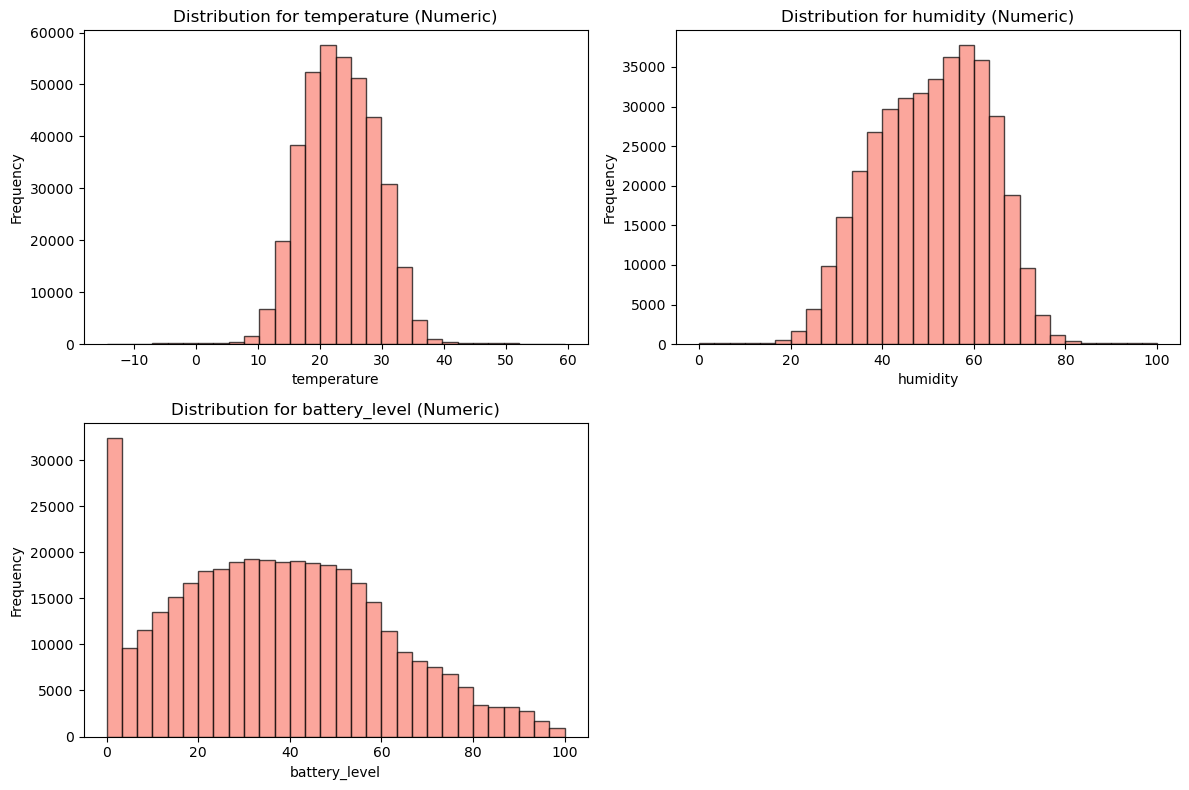

0.029549733797709147


In [34]:
import matplotlib.pyplot as plt

def plot_feature_distributions(df, feature_columns, filename, categorical_features=None):
    """
    Plot the distribution for each feature:
    
    For numerical features - histogram.
    For categorical features - bar graph.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the features.
    feature_columns : list of str
        List of feature column names to plot.
    categorical_features : list of str, optional
        List of features that are categorical. If None, all features are assumed numeric.
    """
    if categorical_features is None:
        categorical_features = []
    
    n_features = len(feature_columns)
    ncols = 2 if n_features > 1 else 1  # use 2 columns if more than one feature
    nrows = (n_features + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
    
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, feature in enumerate(feature_columns):
        ax = axes[i]
        if feature in categorical_features:
            # Bar plot for categorical features
            counts = df[feature].value_counts()
            ax.bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')
            ax.set_title(f'Distribution for {feature} (Categorical)')
            ax.set_xlabel(feature)
            ax.set_ylabel('Count')
        else:
            # Histogram for numeric features
            ax.hist(df[feature].dropna(), bins=30, alpha=0.7, color='salmon', edgecolor='black')
            ax.set_title(f'Distribution for {feature} (Numeric)')
            ax.set_xlabel(feature)
            ax.set_ylabel('Frequency')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()    


os.makedirs("images", exist_ok=True)
t_0 = time.time()
fraction = 1.0
plot_feature_distributions(
    df=df.sample(int(fraction*df.shape[0])),
    feature_columns=['temperature', 'humidity', 'battery_level'],
    filename="images/feature_distribution.png"
    )
    
print((time.time() - t_0)/60)

#### The temperature and humidity seem to reflect what is to be expected for most non-etreme weather enviornments
- the battery_level's distribution is skewed, and is probably a result of capturing data for a device before recharge was completed.

In [35]:
import matplotlib as mpl

def plot_device_time_series_separate(df, filename, device_id=None, start_date=None, period_hours=None):
    """
    Plots the time series of temperature, humidity, and battery level on separate axes.
    If a device_id is given, plot data for that device. Otherwise all devices are plotted.
    If start_date and period_hours are provided, it plots data for the specified period; otherwise, all available data is plotted.
    """
    # stops overflow error in large plots
    mpl.rcParams['agg.path.chunksize'] = 10000  

    if device_id is not None:
        df_filtered = df[df["device_id"] == device_id]
    else:
        df_filtered = df.copy()

    #Sort timestamps
    df_filtered = df_filtered.sort_index()

    #start_date & period_hours, filter by the specified time range
    if start_date is not None and period_hours is not None:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(hours=period_hours)
        df_filtered = df_filtered[(df_filtered.index >= start_date) & (df_filtered.index <= end_date)]

    if df_filtered.empty:
        time_message = ""
        if start_date is not None and period_hours is not None:
            time_message = f" in the time range {start_date} to {end_date}"
        if device_id is not None:
            print(f"No data found for device {device_id}{time_message}")
        else:
            print(f"No data found for any device{time_message}")
        return

    # Create subplots for each feature
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    if device_id is None:
        # Plot for all devices, aith a device_id grouping
        for dev_id, group in df_filtered.groupby("device_id"):
            axes[0].plot(group.index, group["temperature"], marker='o', linestyle='-', label=f"Device {dev_id}")
            axes[1].plot(group.index, group["humidity"], marker='s', linestyle='--', label=f"Device {dev_id}")
            axes[2].plot(group.index, group["battery_level"], marker='d', linestyle='-.', label=f"Device {dev_id}")

        axes[0].set_title("Temperature Over Time for All Devices")
        axes[1].set_title("Humidity Over Time for All Devices")
        axes[2].set_title("Battery Level Over Time for All Devices")
        
        axes[0].legend()
        axes[1].legend()
        axes[2].legend()
    else:
        axes[0].plot(df_filtered.index, df_filtered["temperature"], marker='o', linestyle='-', color='red')
        axes[0].set_title(f"Temperature Over Time for Device {device_id}")
        axes[1].plot(df_filtered.index, df_filtered["humidity"], marker='s', linestyle='--', color='blue')
        axes[1].set_title(f"Humidity Over Time for Device {device_id}")
        axes[2].plot(df_filtered.index, df_filtered["battery_level"], marker='d', linestyle='-.', color='green')
        axes[2].set_title(f"Battery Level Over Time for Device {device_id}")

    for ax in axes:
        ax.set_ylabel("Value")
        ax.grid(True)
    axes[2].set_xlabel("Timestamp")
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

### plot for for a specific device for all times
- plot of all devices at the same time, provides no insight

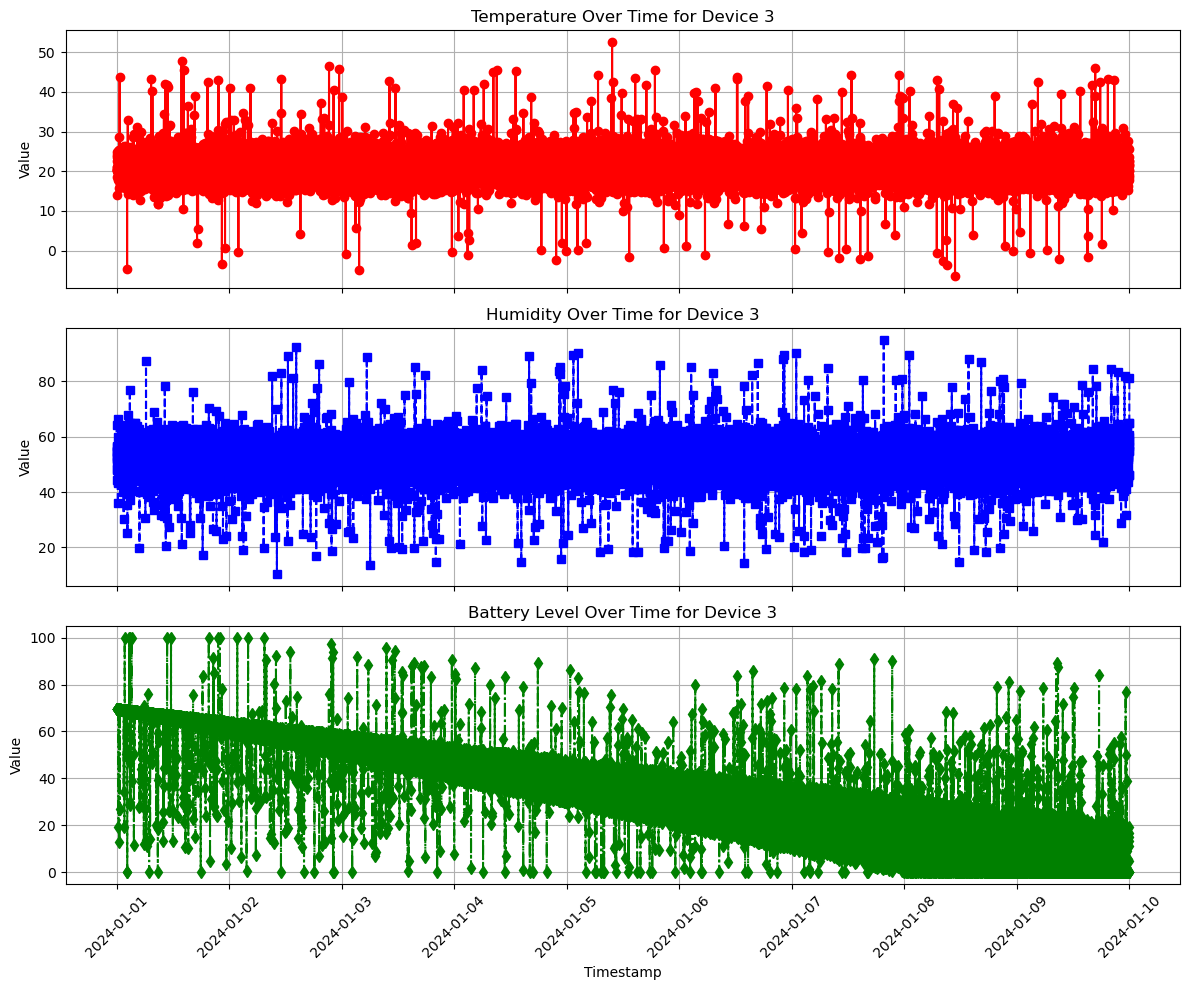

In [36]:
device_id2plot=3
plot_device_time_series_separate(df, filename=f"images/time_series_plot_device_id_{device_id2plot}.png", device_id=device_id2plot)

### Is there evidence of battery degradation above over time?
- unconcluesive possibly sample size is smal or captures battery discharge some how.

#### Time-Series Decomposition

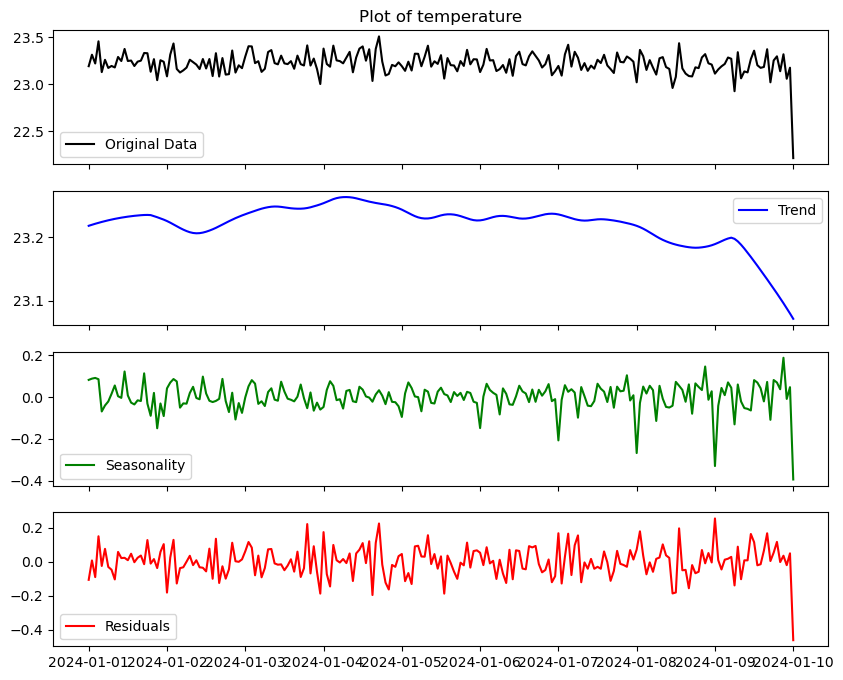

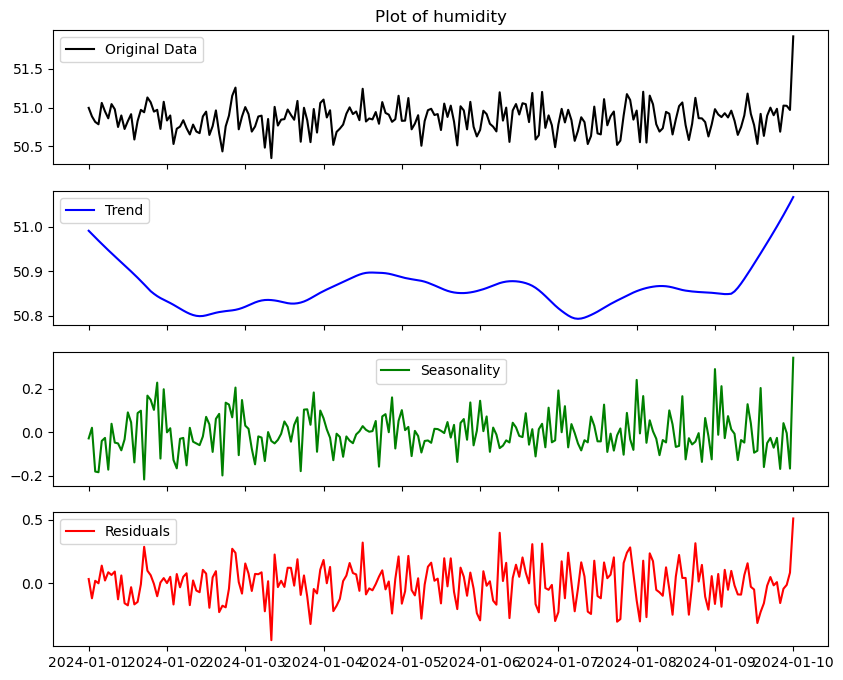

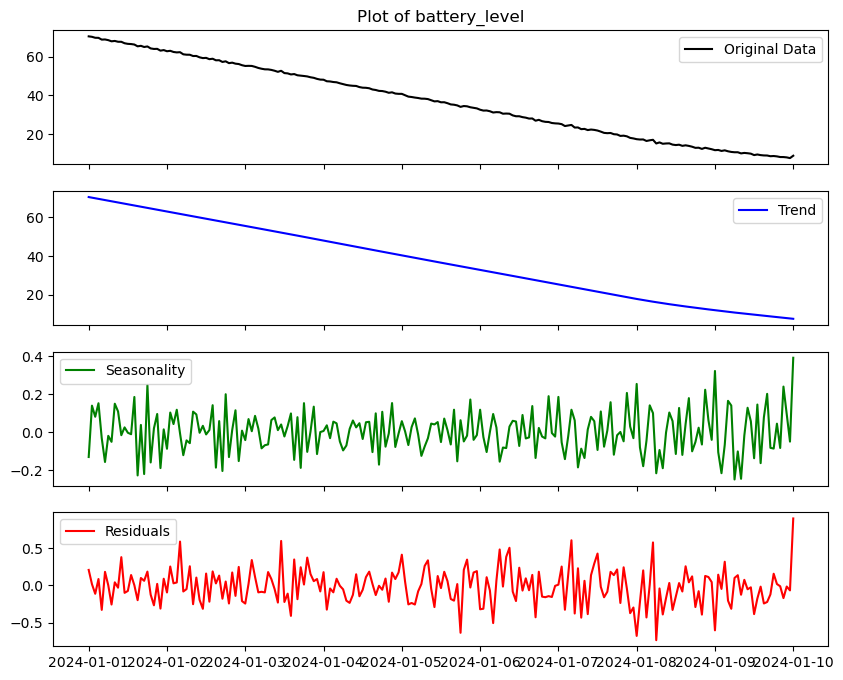

In [37]:
from statsmodels.tsa.seasonal import STL

columns_ = ["temperature", "humidity", "battery_level"]

for i in columns_:
    # Aggregate data by hour (use mean, median, sum, etc. based on your data)
    dx = df.resample("h").mean()  # Adjust as needed
    
    #"Seasonal" period based on hourly data
    seasonal_period = 25  # using 25 to fit algos need for odd numbers, close to 24 for daily patterns
    
    stl = STL(dx[i], seasonal=seasonal_period)
    result = stl.fit()
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    
    axes[0].plot(dx[i], label="Original Data", color="black")
    axes[0].set_title(f"Plot of {i}")
    axes[0].legend()
    
    axes[1].plot(result.trend, label="Trend", color="blue")
    axes[1].legend()
    
    axes[2].plot(result.seasonal, label="Seasonality", color="green")
    axes[2].legend()
    
    axes[3].plot(result.resid, label="Residuals", color="red")
    axes[3].legend()
    plt.savefig(f"images/time_series_decomposition_{i}.png")  
    plt.show()

#### The data captured suggests that battery_level trends down because of them not being recharged
#### There is no seasonality.
#### The temperature and humidity trend appearence at the end is not significant and can be ignored.

### Device-Level Comparisons:

- Box plot
- Time-series plot
- Correlation Matrix Plot
- "Linear Separable" plot

19046


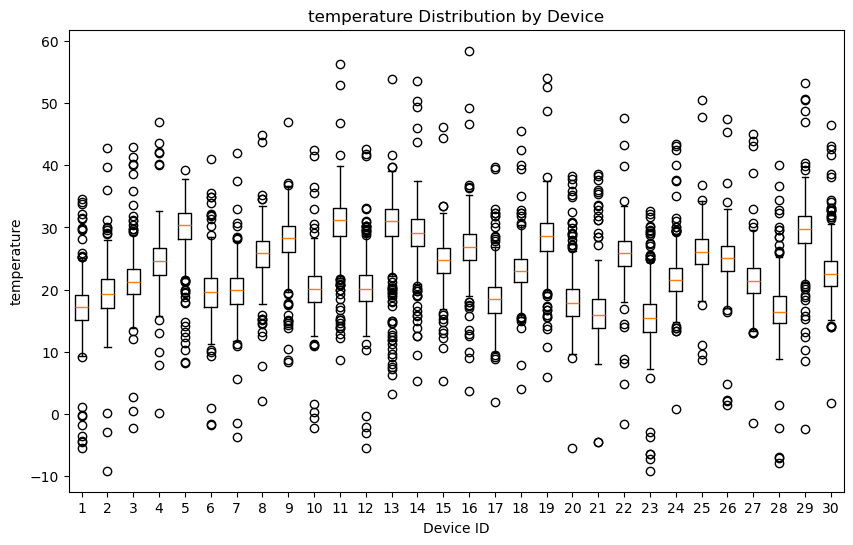

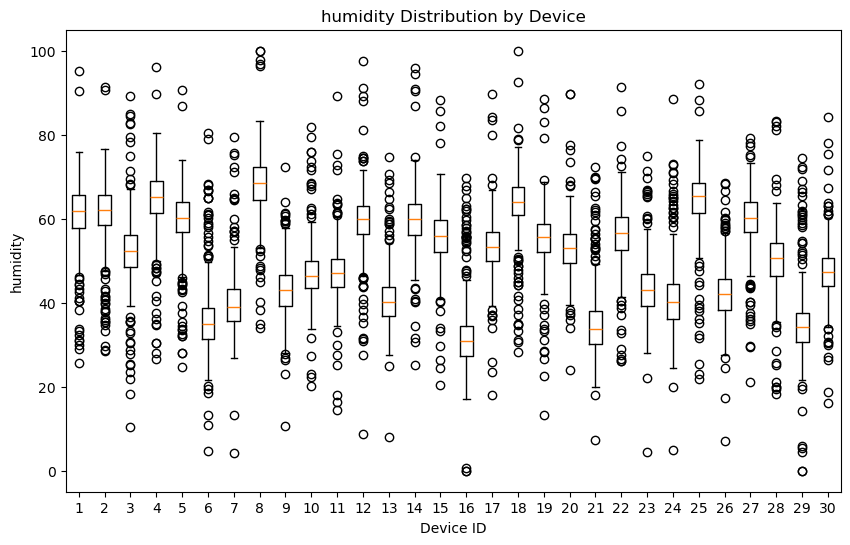

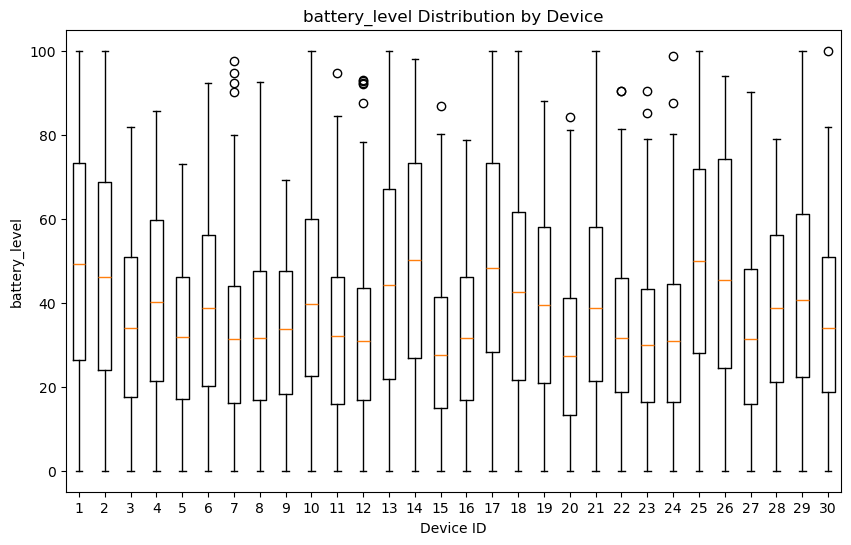

In [38]:
import seaborn as sns

def device_level_distribution(df, data_columns = ['temperature', 'humidity', 'battery_level']):
    # Get unique device IDs and sort them (optional)
    devices = sorted(df['device_id'].unique())
    
    for column in data_columns:
        # Prepare data: list of temperature series for each device
        data = [df[df['device_id'] == device][column] for device in devices]
        
        # Create a box plot
        plt.figure(figsize=(10, 6))
        plt.boxplot(data, labels=devices)
        plt.title(f"{column} Distribution by Device")
        plt.xlabel("Device ID")
        plt.ylabel(f"{column}")        
        plt.savefig(f"images/boxplot_{column}_.png")
        
        plt.show()

fraction = 0.05
print(int(fraction*df.shape[0]))
dx = df.sample(int(fraction*df.shape[0]))
device_level_distribution(dx)

<img src="images\reference\box_plot.jpg" alt="My Image" width="400" height="300">

#### A sub-sample was used to make the data more readable. The sampling uses a uniform distribution, a non preferential sampling process.
#### For the extreme values at the end of the whiskers:
- temperature - most device are not located in the same region.
- humidity - same as above
- battery_level - suggests that most batteries are not fully charged, so instances where they are fully charrged hsows as extreme values. More evidence that outliers are not significant
- A more representative population is needed to build an optimally performing model.

### plot for a period of specified hours from a start date for a specific device -- 24days

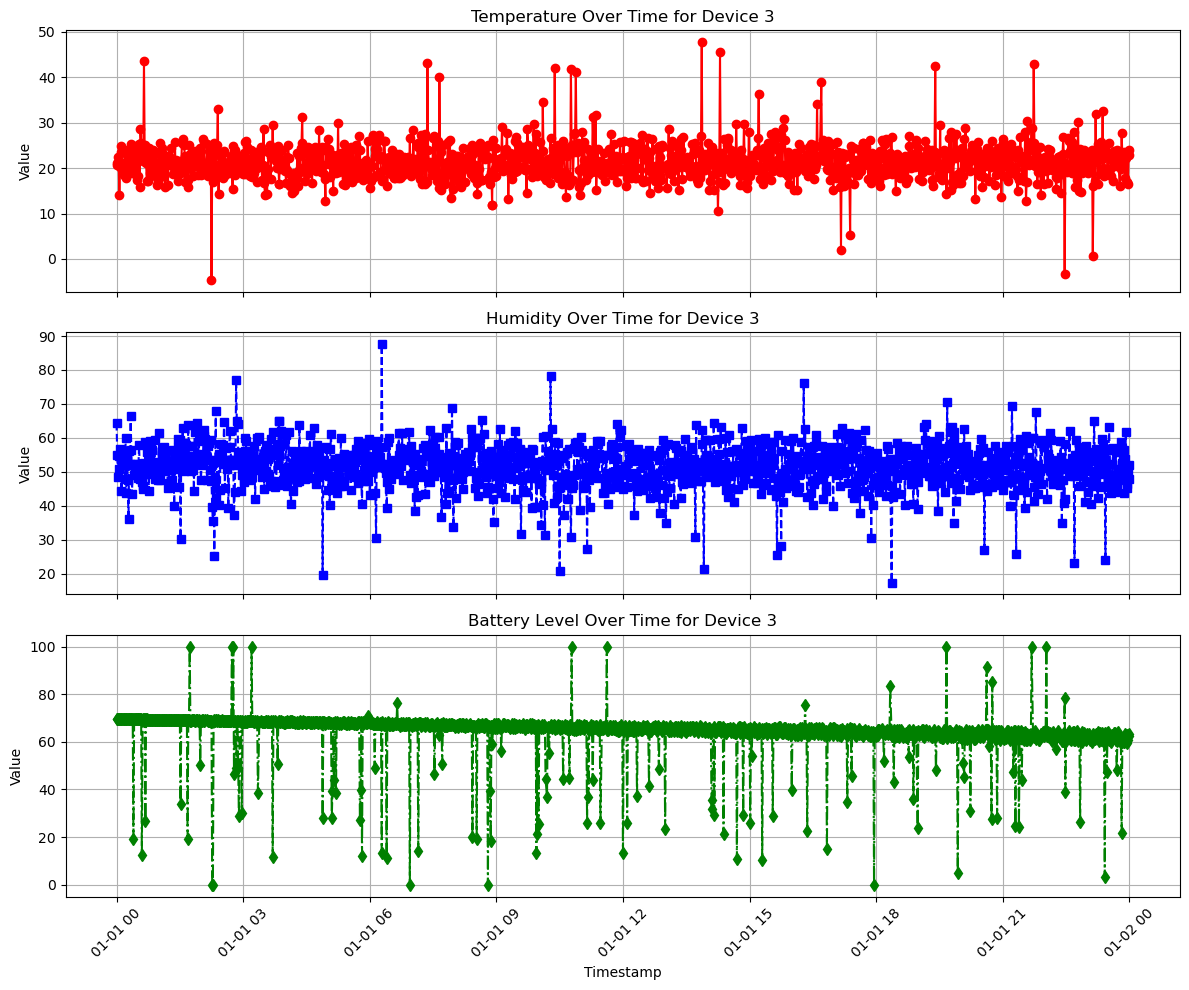

In [39]:
device_id2plot=3 #chosen from box plot, since it hase a wid range, relatively lw median, and no extreme values
plot_device_time_series_separate(df, filename=f"images/time_series_plot_device_id_{device_id2plot}_1_1_2024_startdate_24hrs.png", device_id=device_id2plot, start_date="2024-01-01 00:00:00", period_hours=24)

In [40]:
#Compute the correlation matrix for temperature, humidity, and battery_level
def corr_matrix_correlated(df, filename):
    corr_matrix = df[['temperature', 'humidity', 'battery_level']].corr()
    print("Correlation Matrix:")
    print(corr_matrix)
    
    # Optionally, visualize the correlations with scatter plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Temperature vs Humidity
    axes[0].scatter(df['temperature'], df['humidity'])
    axes[0].set_xlabel('Temperature (°C)')
    axes[0].set_ylabel('Humidity (%)')
    axes[0].set_title('Temperature vs Humidity')
    
    # Temperature vs Battery Level
    axes[1].scatter(df['temperature'], df['battery_level'])
    axes[1].set_xlabel('Temperature (°C)')
    axes[1].set_ylabel('Battery Level (%)')
    axes[1].set_title('Temperature vs Battery Level')
    
    # Humidity vs Battery Level
    axes[2].scatter(df['humidity'], df['battery_level'])
    axes[2].set_xlabel('Humidity (%)')
    axes[2].set_ylabel('Battery Level (%)')
    axes[2].set_title('Humidity vs Battery Level')
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

1904
Correlation Matrix:
               temperature  humidity  battery_level
temperature       1.000000 -0.003155       0.077611
humidity         -0.003155  1.000000       0.034293
battery_level     0.077611  0.034293       1.000000


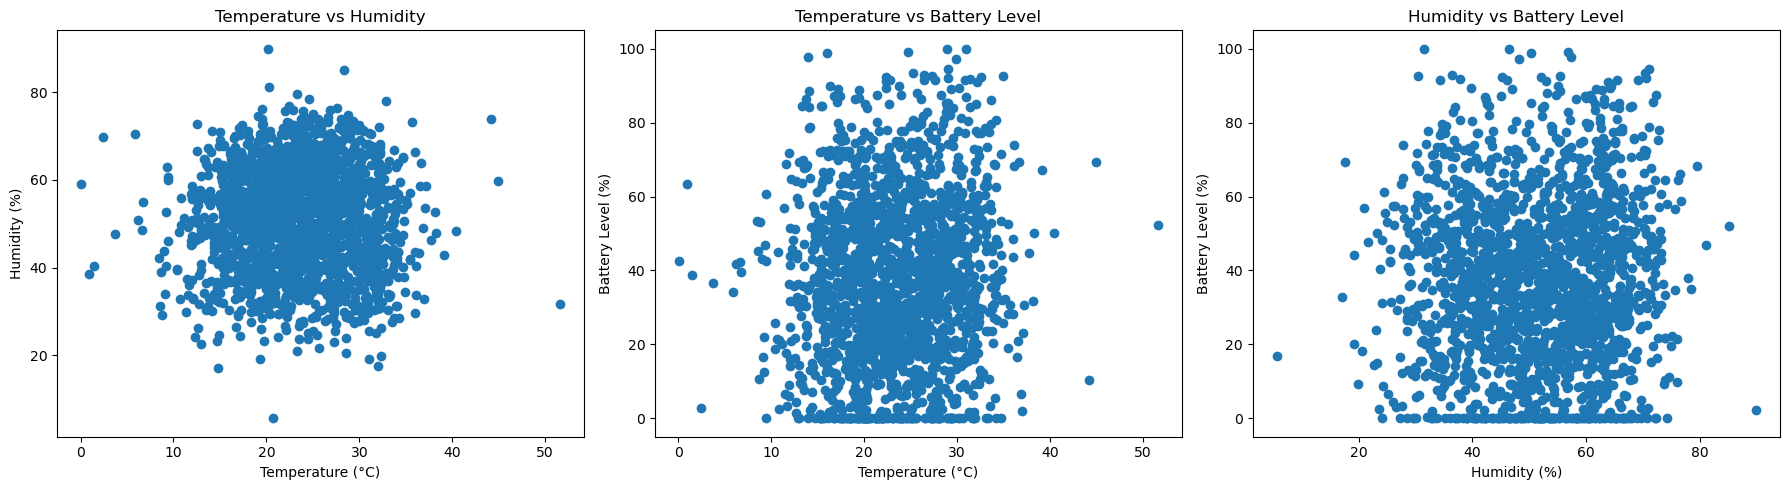

In [41]:
fraction = 0.005
print(int(fraction*df.shape[0]))
dx = df.sample(int(fraction*df.shape[0]))
corr_matrix_correlated(dx, filename="images/correlation_plots.png")

### features dont seem to be correlated, but viewing for one devic may say otherwise

Correlation Matrix:
               temperature  humidity  battery_level
temperature       1.000000  0.031799      -0.006897
humidity          0.031799  1.000000      -0.010758
battery_level    -0.006897 -0.010758       1.000000


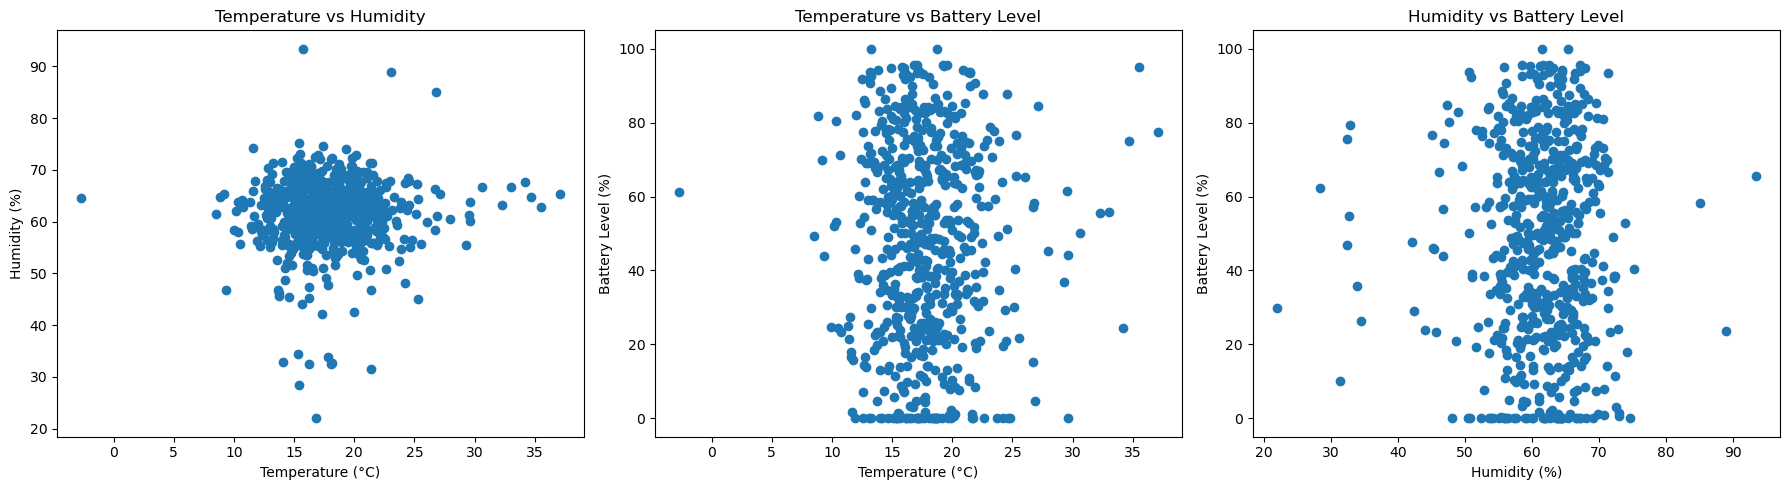

In [42]:
fraction = 0.05
device_id = 1 #shown in box plot as having no extreme values
dx = df.sample(int(fraction*df.shape[0]))
corr_matrix_correlated(dx[dx["device_id"]==device_id], filename=f"images/correlation_plots_device_{device_id}.png")

Correlation Matrix:
               temperature  humidity  battery_level
temperature       1.000000 -0.011474       0.046489
humidity         -0.011474  1.000000      -0.051097
battery_level     0.046489 -0.051097       1.000000


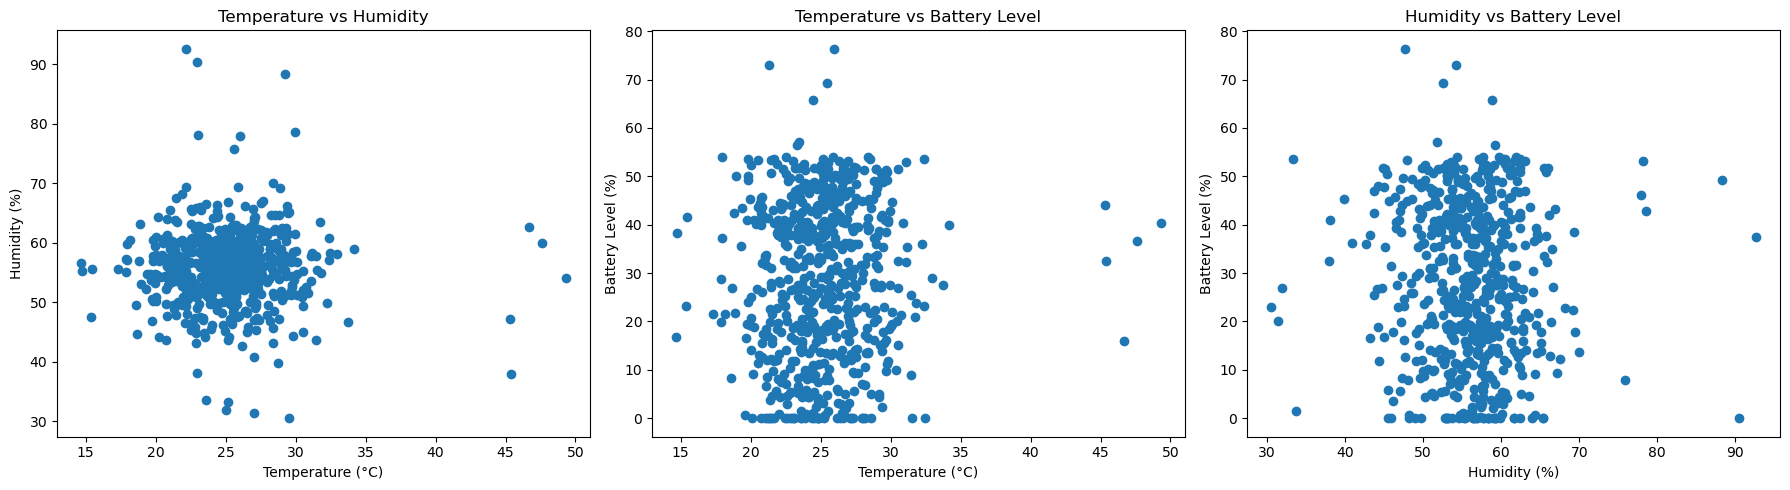

In [43]:
fraction = 0.05
device_id = 15 #shown in box plot as having extreme values
dx = df.sample(int(fraction*df.shape[0]))
corr_matrix_correlated(dx[dx["device_id"]==device_id], filename=f"images/correlation_plots_device_{device_id}.png")

del dx

#### consider possible device communication and timestamp issue

952


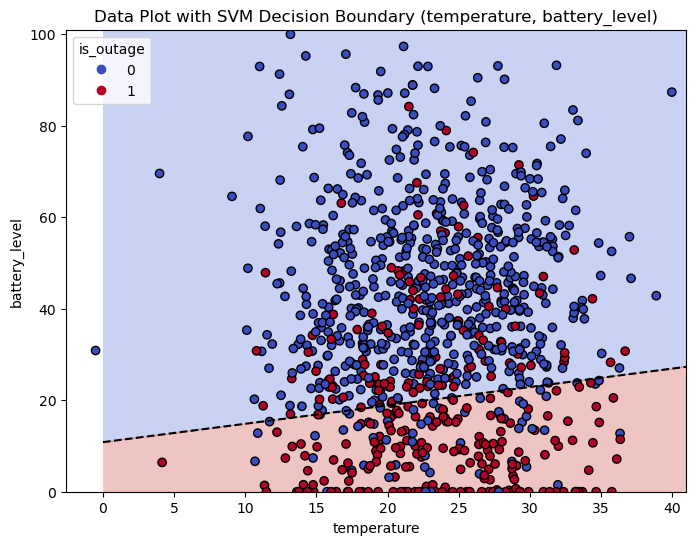

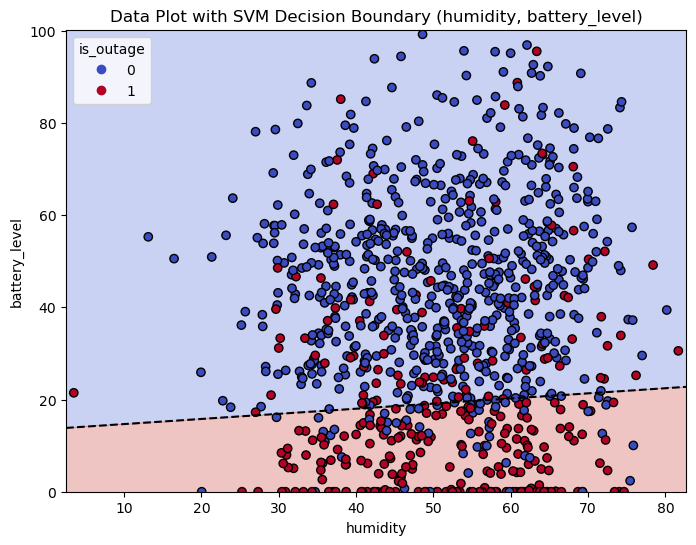

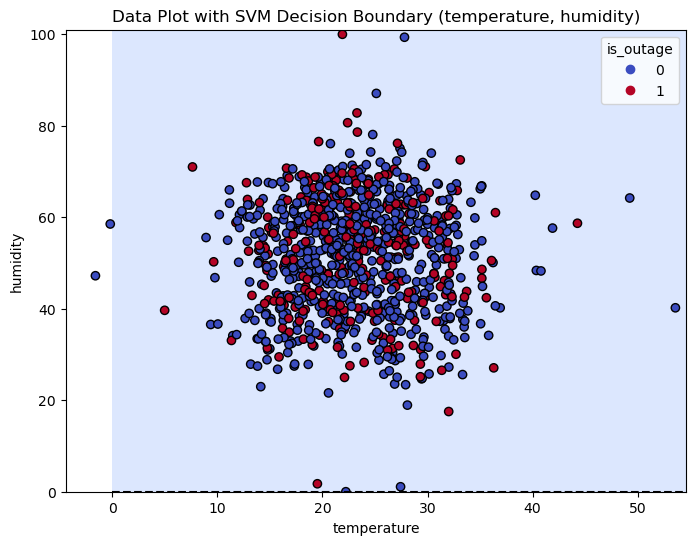

0.6029879252115885

In [44]:
from sklearn.svm import SVC

def plot_decision_boundary(df, feature_columns, target_column, filename):
    """
    Plot the data and the decision boundary of a linear SVM using a DataFrame. Used to determine if data is ilinearly seperable.
    """
    # Extract features (X) and target (y) from the DataFrame
    X = df[feature_columns].values
    y = df[target_column].values
    
    # Fit a linear SVM model
    svm_model = SVC(kernel='linear')
    svm_model.fit(X, y)
    
    # Create a mesh grid for plotting decision regions
    x_min, x_max = max(X[:, 0].min() - 1, 0), X[:, 0].max() + 1  # Ensure non-negative values
    y_min, y_max = max(X[:, 1].min() - 1, 0), X[:, 1].max() + 1  # Ensure non-negative values
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Predict across the grid
    Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision regions and data points
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    
    # Plot the SVM decision boundary line (for linear SVMs)
    w = svm_model.coef_[0]
    b = svm_model.intercept_[0]
    x_line = np.linspace(x_min, x_max, 100)
    y_line = -(w[0] / w[1]) * x_line - (b / w[1])
    y_line = np.clip(y_line, 0, None)  # no negatives in plot
    plt.plot(x_line, y_line, 'k--', label="Decision Boundary")
    
    plt.xlabel(feature_columns[0])
    plt.ylabel(feature_columns[1])
    plt.title(f"Data Plot with SVM Decision Boundary ({feature_columns[0]}, {feature_columns[1]})")
    plt.legend(*scatter.legend_elements(), title=target_column)
    plt.savefig(filename)
    plt.show()

#this is not time dependednt analysis so can run a mormal distributed sample without data loss - using all data is not necc. Basically sampling a smaller sized dataframe reduces process time
t_0 = time.time()
fraction = 0.0025
print(int(fraction*df.shape[0]))
plot_decision_boundary(df.sample(int(fraction*df.shape[0])), ['temperature', 'battery_level'], 'is_outage', filename="images/decision_boundary_temperature_battery_level.png")
plot_decision_boundary(df.sample(int(fraction*df.shape[0])), ['humidity', 'battery_level'], 'is_outage', filename="images/decision_boundary_humidity_battery_level.png")
plot_decision_boundary(df.sample(int(fraction*df.shape[0])), ['temperature', 'humidity'], 'is_outage', filename="images/decision_boundary_temperature_humidity.png")
(time.time() - t_0)/60

#### data does not appear to be lineraly seperable, this suggests that linear model will not be useful. Like Logistic regression, Perceptron, or Linear SVMs.

# Feature Engineering

There are potential temporal features that can be engineered with caveats. Since the battery darinage can lead to outages, from a physic and chemistry point of view, battery_level seems like a good choice. EDA has shown that there instances hwre battreies are draining. So for a  device-level 'attack', the following can be tried:

1. Rolling window Volatility Measurement: use a rolling standard deviation to show 5pm MT variability over a set window. This might show unstable periods.
2. Change Detection:: This could show the dynamics of the variable, e.g "how quickly the battery is draining".
3. Trending Acceleration/Deceleration (suggested in some EDA plots): Used to understand possible sudden large differences, that may be related to outages.

These are physically motivated, but they were not implemented. I made this decision because the data set is not large enough, and the model buil without them, is performant. The chance of over-fiotty woul dmost likely increase.

In [45]:
    """"
    Engineer potential temporal features for battery degradation analysis.
    
    This function adds three features based on the battery_level data:
    1. Rolling Window Volatility Measurement: A rolling standard deviation over a set window (e.g., 5 time steps)
       to capture variability (e.g., around 5pm MT or similar periods) and identify unstable periods.
    2. Change Detection: The first difference of battery_level to quantify how quickly the battery is draining.
    3. Trending Acceleration/Deceleration: The second difference (difference of the first difference) to capture 
       sudden large changes that might be associated with outages.
    
    Caveats:
      - These features are physically motivated but were not implemented in the final model due to the small dataset size.
      - Adding these features may increase the chance of overfitting if the data set is not large enough.
    
    Parameters:
      df: A pandas DataFrame that includes a 'battery_level' column.
    
    Returns:
      A DataFrame with the new temporal feature columns added.
    """

'"\nEngineer potential temporal features for battery degradation analysis.\n\nThis function adds three features based on the battery_level data:\n1. Rolling Window Volatility Measurement: A rolling standard deviation over a set window (e.g., 5 time steps)\n   to capture variability (e.g., around 5pm MT or similar periods) and identify unstable periods.\n2. Change Detection: The first difference of battery_level to quantify how quickly the battery is draining.\n3. Trending Acceleration/Deceleration: The second difference (difference of the first difference) to capture \n   sudden large changes that might be associated with outages.\n\nCaveats:\n  - These features are physically motivated but were not implemented in the final model due to the small dataset size.\n  - Adding these features may increase the chance of overfitting if the data set is not large enough.\n\nParameters:\n  df: A pandas DataFrame that includes a \'battery_level\' column.\n\nReturns:\n  A DataFrame with the new tem

In [46]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

def remove_nan_rows(dz):
    """
    Removes all rows with at least one NaN value from the DataFrame.
    
    Parameters:
        dz (pd.DataFrame): Input DataFrame.
        
    Returns:
        pd.DataFrame: DataFrame with rows containing NaN removed.
    """
    # Drop any row that contains at least one NaN value
    cleaned_dz = dz.dropna()
    return cleaned_dz

def remove_nan_and_inf_rows(df):
    """
    Replace infinite values with NaN and drop rows that contain any NaN.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
    
    Returns:
        pd.DataFrame: Cleaned DataFrame without any NaN or infinite values.
    """
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    return df_clean.dropna()


def Investigate_NULLS(df):
    columns = df.columns
    for column_ in columns:
        missing_mask = df[column_].isna()
        #print(f"Missing values for? {column_}:")
        
        # Count the total number of missing values in column_
        missing_count = df[column_].isna().sum()
        print('-------------------------------')
        print(f"Total missing values in {column_}':", missing_count, "\n")

def engineer_temporal_features(dz):
    dz = dz.copy()
    
    # Rolling statistics for battery_level over a window of 5 time steps
    dz['battery_level_roll_std_5'] = dz['battery_level'].rolling(window=5).std()
    dz['battery_level_roll_mean_5'] = dz['battery_level'].rolling(window=5).mean()
    
    # Difference Features: First and second differences of battery_level
    dz['battery_level_change'] = dz['battery_level'].diff()
    dz['battery_level_trend'] = dz['battery_level_change'].diff()
    
    # Lag Features: Previous time steps (lags by 1 and 2)
    dz['battery_level_lag_1'] = dz['battery_level'].shift(1)
    dz['battery_level_lag_2'] = dz['battery_level'].shift(2)
    
    # Rate of Change: Percentage change in battery_level
    dz['battery_level_rate'] = dz['battery_level'].pct_change()
    
    # If a timestamp column exists, extract time components and apply cyclical encoding.
    if 'timestamp' in dz.columns:
        dz['timestamp'] = pd.to_datetime(dz['timestamp'])
        # Extract simple time components
        dz['hour'] = dz['timestamp'].dt.hour
        dz['day_of_week'] = dz['timestamp'].dt.dayofweek
        
        # Cyclical Encoding for hour-of-day (sine and cosine transformation)
        dz['hour_sin'] = np.sin(2 * np.pi * dz['hour'] / 24)
        dz['hour_cos'] = np.cos(2 * np.pi * dz['hour'] / 24)
        
        # Optionally, cyclical encoding for day_of_week can also be applied:
        dz['dow_sin'] = np.sin(2 * np.pi * dz['day_of_week'] / 7)
        dz['dow_cos'] = np.cos(2 * np.pi * dz['day_of_week'] / 7)
    
    # You can also add interaction features or polynomial features if needed.
    # For example, if there are temperature and humidity columns:
    if 'temperature' in dz.columns and 'humidity' in dz.columns:
        # Interaction feature (multiplicative)
        dz['temp_humidity_interaction'] = dz['temperature'] * dz['humidity']
        
        # Example of a quadratic term if needed:
        dz['temperature_sq'] = dz['temperature'] ** 2
    
    return dz

if __name__ == "__main__":
    t_0 = time.time()
    filename = "ipmuted_data_timestamp_index.csv"
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    print(df.index.dtype)
    print(df.columns)
    print((time.time() - t_0)/60)
    print("=====================\n")
    
    dx = engineer_temporal_features(df)
    print("BEFORE remove NAN: ", dx.shape)
    dx = remove_nan_rows(dx)
    print("AFTER remove NAN: ", dx.shape)
    
    print("NULLS after REMOVE NAN")
    Investigate_NULLS(dx)
    
    print(list(dx.columns))
    print(list(df.columns))
    
    dx = engineer_temporal_features(df)
    
    engineered_features = list(set(dx.columns).difference(set(df.columns)))
    
    dx = remove_nan_and_inf_rows(dx) #during feature engineering, possible inf or -inf, or unbounded number was introduce. More than likely due to rolling window; I did not track it down.
    
    df = dx

datetime64[ns]
Index(['device_id', 'temperature', 'humidity', 'battery_level',
       'device_status', 'is_outage', 'group', 'isna'],
      dtype='object')
0.012453039487202963

BEFORE remove NAN:  (380932, 17)
AFTER remove NAN:  (373403, 17)
NULLS after REMOVE NAN
-------------------------------
Total missing values in device_id': 0 

-------------------------------
Total missing values in temperature': 0 

-------------------------------
Total missing values in humidity': 0 

-------------------------------
Total missing values in battery_level': 0 

-------------------------------
Total missing values in device_status': 0 

-------------------------------
Total missing values in is_outage': 0 

-------------------------------
Total missing values in group': 0 

-------------------------------
Total missing values in isna': 0 

-------------------------------
Total missing values in battery_level_roll_std_5': 0 

-------------------------------
Total missing values in battery_level_r

# Feature importance

sample size:  35681
Unique values in 'is_outage': [0 1]


C:\Users\Damion\AppData\Local\Temp\ipykernel_14536\3934958668.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('is_outage', group_keys=False).apply(lambda x: x.sample(n=desired_counts[x.name], random_state=42))


Unique predicted values: [0 1]
RandomForest Feature Importances:
                      Feature  Importance
3               device_status    0.545045
4   battery_level_roll_mean_5    0.148475
2               battery_level    0.080561
9         battery_level_lag_2    0.052847
11        battery_level_lag_1    0.038853
6          battery_level_rate    0.032396
1                    humidity    0.015883
5    battery_level_roll_std_5    0.015780
7        battery_level_change    0.014846
0                 temperature    0.014370
8              temperature_sq    0.014110
10        battery_level_trend    0.014104
12  temp_humidity_interaction    0.012730


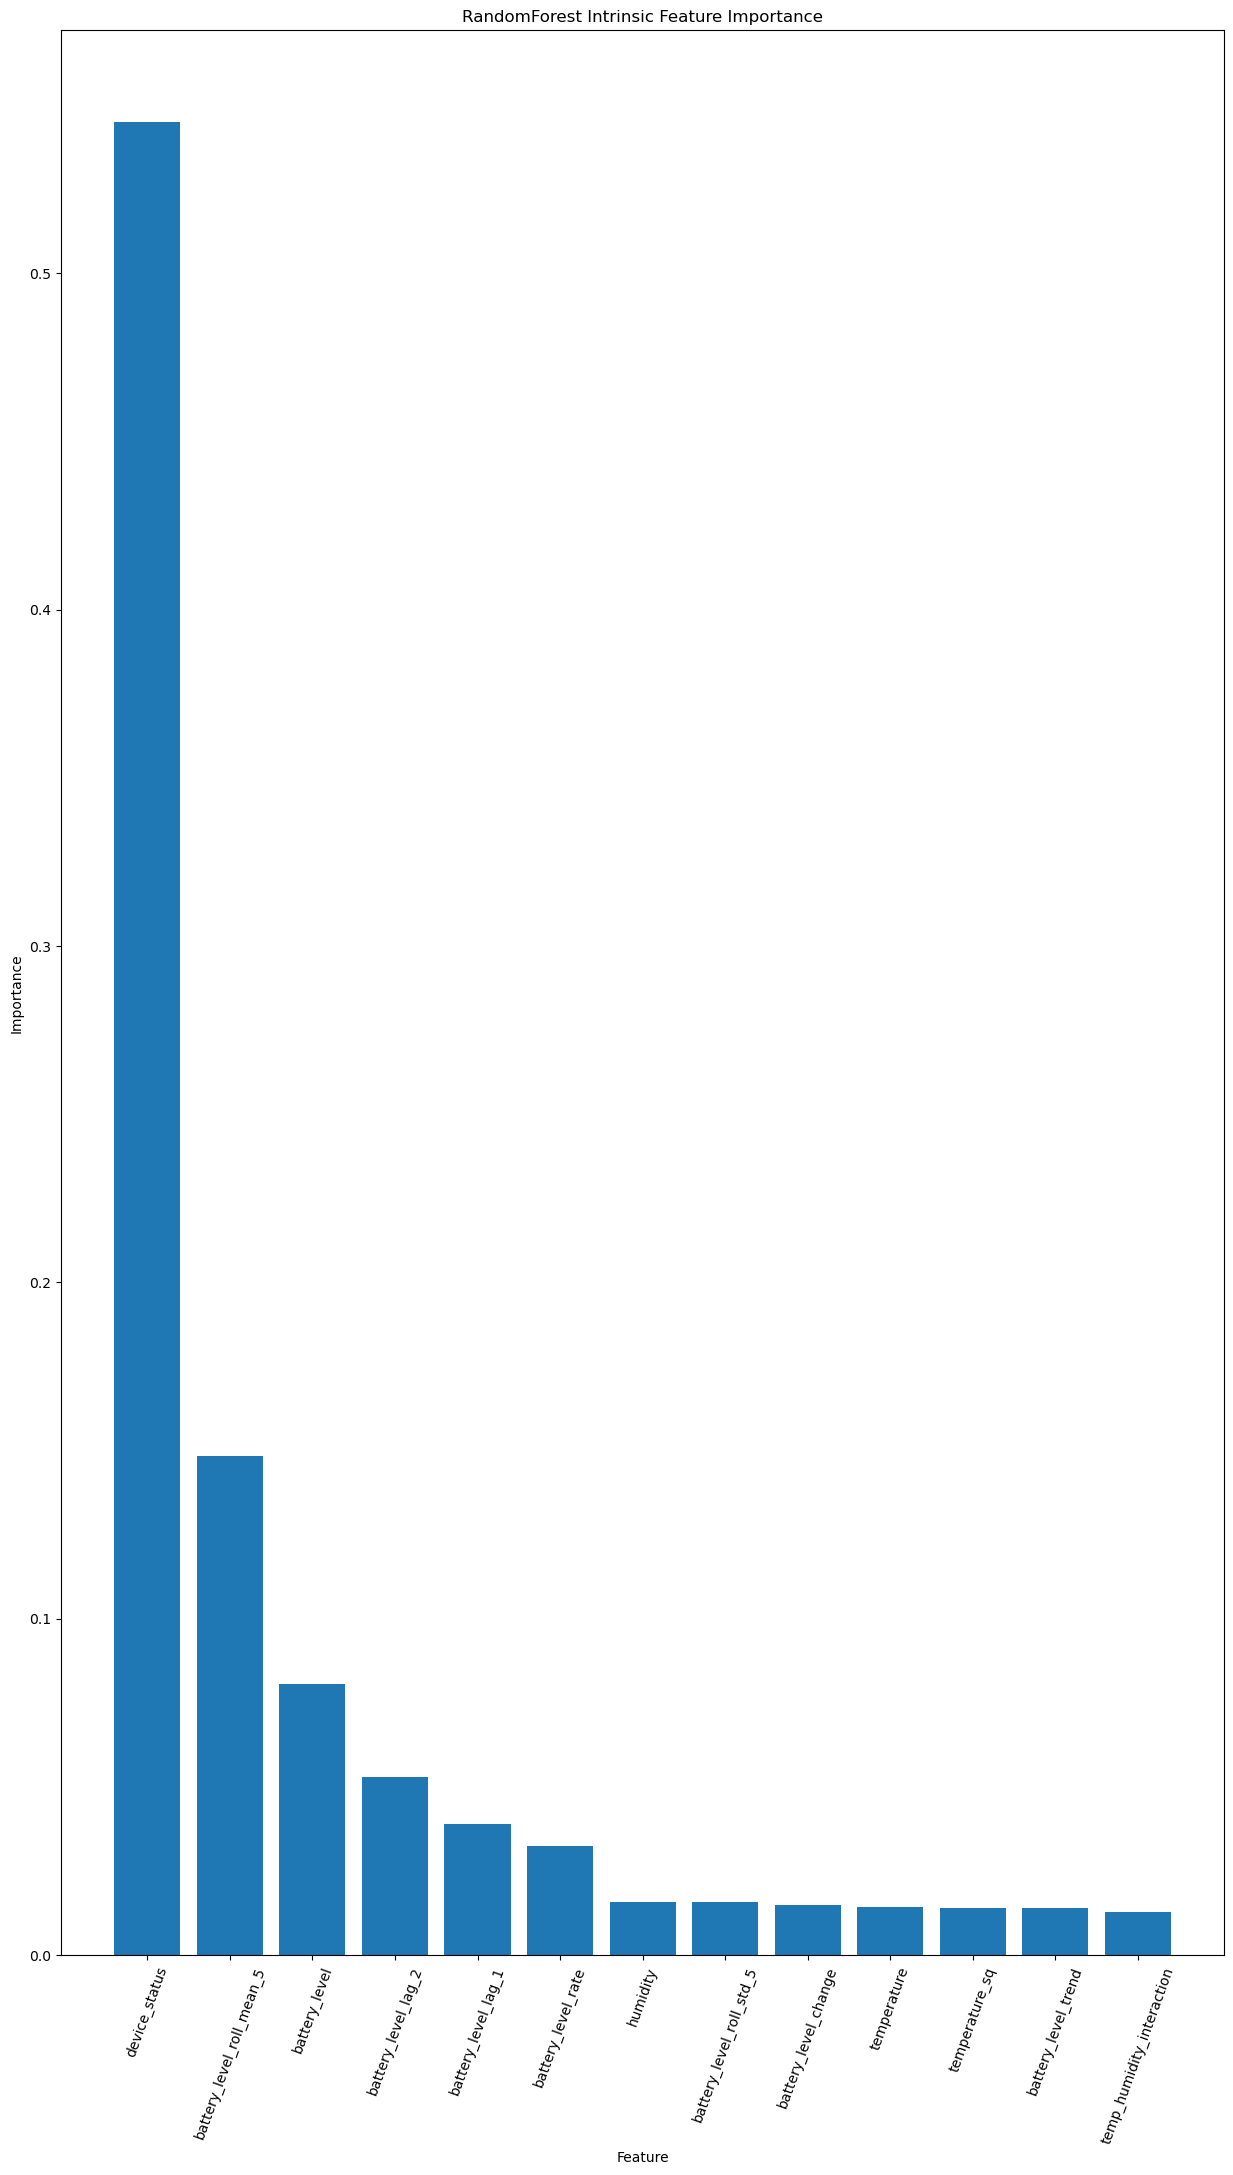

Permutation Importances:
                      Feature  Importance
3               device_status    0.418358
2               battery_level    0.017040
4   battery_level_roll_mean_5    0.016620
9         battery_level_lag_2    0.012388
11        battery_level_lag_1    0.008997
5    battery_level_roll_std_5    0.008436
1                    humidity    0.008072
0                 temperature    0.007567
6          battery_level_rate    0.007539
10        battery_level_trend    0.006110
7        battery_level_change    0.005998
12  temp_humidity_interaction    0.004989
8              temperature_sq    0.004961


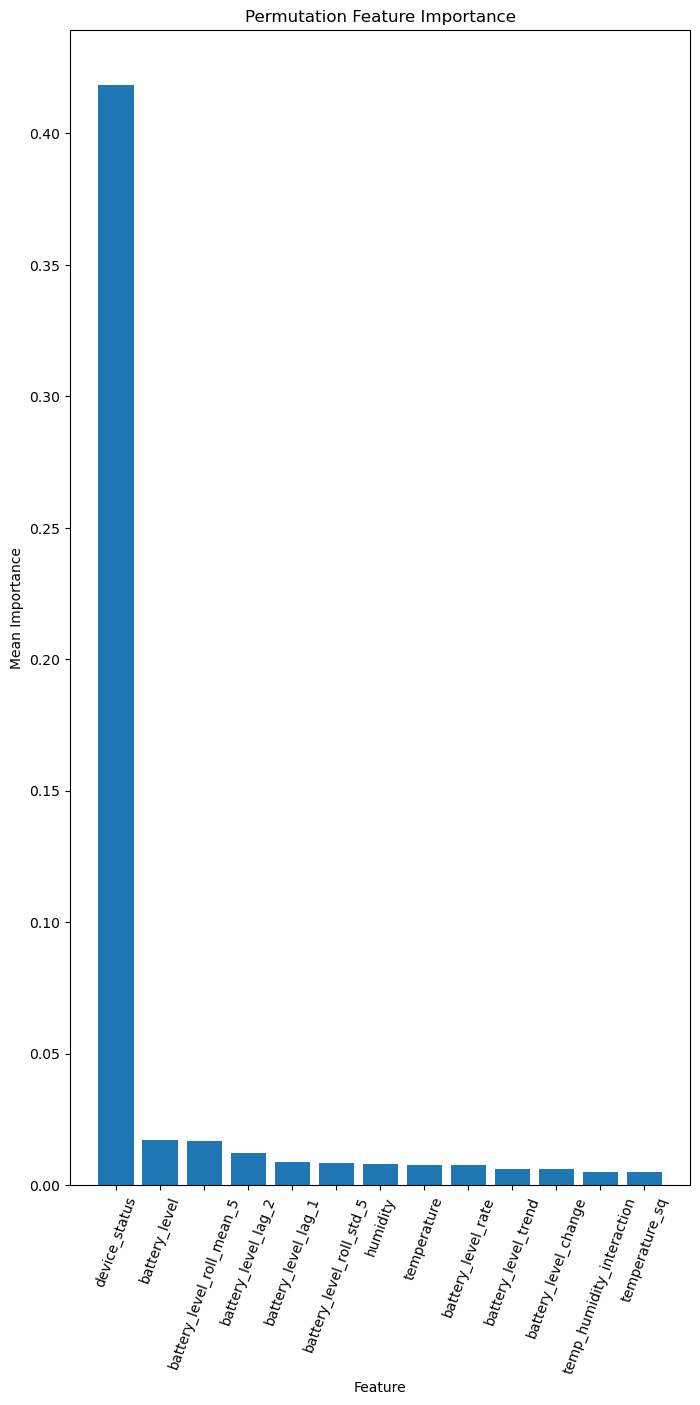

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

def feature_importance_calc(df, features=['temperature', 'humidity', 'battery_level', 'device_status'], frac_=0.1):
    rotation_=70
    
    print("Unique values in 'is_outage':", df['is_outage'].unique())
    
    # Using stratified sampling to makes sure both classes are seen in the sample, 
    # uisng sample counts for each group similar what was found earlier in EDA
    n_total = int(frac_*df.shape[0])
    n_class0 = int(n_total * 0.3)
    n_class1 = n_total - n_class0
    desired_counts = {0: n_class0, 1: n_class1}

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)   
    df_sample = df.groupby('is_outage', group_keys=False).apply(lambda x: x.sample(n=desired_counts[x.name], random_state=42))
    
    #features = ['temperature', 'humidity', 'battery_level', 'device_status']
    X = df_sample[features]
    y = df_sample['is_outage'].astype(int)
    
    # Train RandomForestClassifier with all cores
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    clf.fit(X, y)
    
    y_pred = clf.predict(X)
    print("Unique predicted values:", np.unique(y_pred))
    
    #Method 1: Intrinsic Feature Importances
    importances = clf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("RandomForest Feature Importances:")
    print(importance_df)
    
    # Plot intrinsic feature importances
    plt.figure(figsize=(15, 25))
    plt.bar(importance_df['Feature'], importance_df['Importance'])
    plt.title("RandomForest Intrinsic Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.xticks(rotation=rotation_)
    plt.savefig("images/RandomForest_Intrinsic_Feature_Importance.png")
    plt.show()
    
    #Method 2: Permutation Importance
    perm_result = permutation_importance(
        clf, X, y, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    perm_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': perm_result.importances_mean
    })
    
    perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
    print("Permutation Importances:")
    print(perm_importance_df)
    
    # Plot permutation feature importances
    plt.figure(figsize=(8, 15))
    plt.bar(perm_importance_df['Feature'], perm_importance_df['Importance'])
    plt.title("Permutation Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Mean Importance")
    plt.xticks(rotation=rotation_)
    plt.savefig("images/Permutation_Feature_Importance.png")
    plt.show()

    return importance_df, perm_importance_df
    
if __name__ == "__main__":
    t_0 = time.time()
    fraction = 0.1
    print("sample size: ", int(fraction*df.shape[0]))
    
    features_ = ['temperature', 'humidity', 'battery_level', 'device_status']
    features_ = features_ + engineered_features
    
    #importance_df = 
    importance_df, perm_importance_df = feature_importance_calc(df.sample(int(fraction*df.shape[0])), features_, fraction)
    (time.time() - t_0)/60

In [48]:
importance_df

,Feature,Importance
3,device_status,0.545045
4,battery_level_roll_mean_5,0.148475
2,battery_level,0.080561
9,battery_level_lag_2,0.052847
11,battery_level_lag_1,0.038853
6,battery_level_rate,0.032396
1,humidity,0.015883
5,battery_level_roll_std_5,0.015780
7,battery_level_change,0.014846
0,temperature,0.014370


In [49]:
perm_importance_df

,Feature,Importance
3,device_status,0.418358
2,battery_level,0.017040
4,battery_level_roll_mean_5,0.016620
9,battery_level_lag_2,0.012388
11,battery_level_lag_1,0.008997
5,battery_level_roll_std_5,0.008436
1,humidity,0.008072
0,temperature,0.007567
6,battery_level_rate,0.007539
10,battery_level_trend,0.006110


#### All features should be retained

#### Model Choice:

#### Model Performance:

The results indicate that the model is robust and performant.
    •	The best cross-validation score (CV Score) given in the report is quite high. This basically says that while training, the model was consistent across different folds.
    •	The accuracy, precision, recall, f1-score are also high and further support this.
    •	The Validation & Test Set evaluation were very similar. This means that the model generalizes well beyond the training data.
    •	The ROC curve abd AUC suggets and excellent fit.
    •	Hyperparameter Tuning was highly effective. The hyperparameters were chosen using Bayesian optimization and gave excellent results.ts.

C:\Users\Damion\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


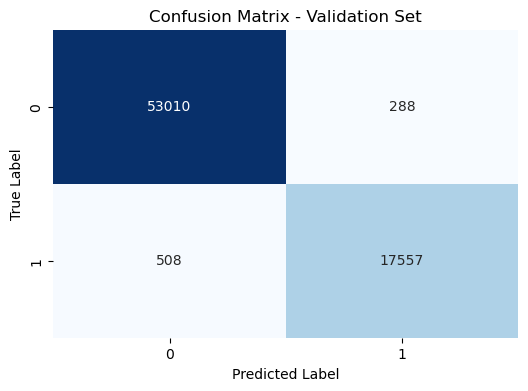

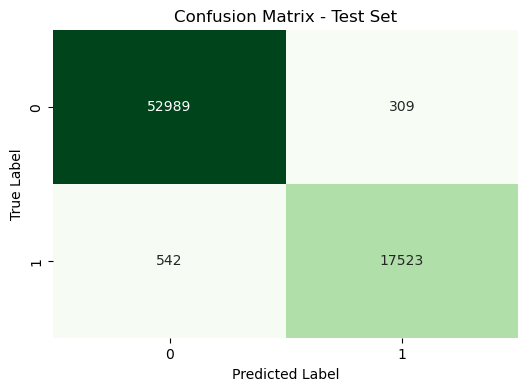

Best Parameters: OrderedDict({'learning_rate': 0.06610098295419149, 'max_depth': 8})
Best CV Score: 0.9882711240311585

Validation Set Evaluation:
Accuracy: 0.9888457604080546
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     53298
           1       0.98      0.97      0.98     18065

    accuracy                           0.99     71363
   macro avg       0.99      0.98      0.99     71363
weighted avg       0.99      0.99      0.99     71363


Test Set Evaluation:
Accuracy: 0.9880750528985609
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     53298
           1       0.98      0.97      0.98     18065

    accuracy                           0.99     71363
   macro avg       0.99      0.98      0.98     71363
weighted avg       0.99      0.99      0.99     71363

Validation Logloss: 0.0613069026409323
Test Logloss: 0.0644984531155586

In [50]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss

def train_xgb_model(df, features = ['temperature', 'humidity', 'battery_level', 'device_status']):
    # """
    # Train an XGBoost classifier using Bayesian Optimization for hyperparameter tuning.
    # This function computes, visualizes, and saves confusion matrices as heat maps.
        
    # Returns:
    #   A dictionary containing the trained model, best hyperparameters, best CV score,
    #   validation metrics, and test metrics.
    # """
    # Define features and target variable
    
    # features = ['temperature', 'humidity', 'battery_level', 'device_status']
    
    # features = features_ 
    target = 'is_outage'
    
    X = df[features]
    y = df[target]
    
    # Split the data into train (60%), validation (20%), and test (20%) sets with stratification
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )
    # Now: train (60%), validation (20%), test (20%)
    
    # Set up the XGBoost model with parallelization
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    
    # Define the hyperparameter search space for learning_rate and max_depth.
    param_space = {
        'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
        'max_depth': Integer(3, 10)
    }
    
    # Set up k-fold cross-validation (5 folds)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Set up Bayesian Optimization using BayesSearchCV from scikit-optimize
    bayes_search = BayesSearchCV(
        estimator=xgb_model,
        search_spaces=param_space,
        n_iter=20,            # Number of parameter settings sampled
        cv=kfold,
        scoring='accuracy',   
        n_jobs=-1,            # Use all available cores
        verbose=0,
        random_state=42
    )
    
    # Train the model using Bayesian Optimization (with cross-validation)
    bayes_search.fit(X_train, y_train)
    
    # Retrieve the best hyperparameters and best CV score
    best_params = bayes_search.best_params_
    best_cv_score = bayes_search.best_score_
    
    # Evaluate on the Validation set
    y_val_pred = bayes_search.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred)
    
    # Compute confusion matrix for the validation set
    cm_val = confusion_matrix(y_val, y_val_pred)
    
    # Evaluate on the Test set
    y_test_pred = bayes_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)
    
    # Compute confusion matrix for the test set
    cm_test = confusion_matrix(y_test, y_test_pred)

    # compute the logloss
    # For the validation set
    y_val_proba = bayes_search.predict_proba(X_val)
    val_logloss = log_loss(y_val, y_val_proba)
    
    # For the test set
    y_test_proba = bayes_search.predict_proba(X_test)
    test_logloss = log_loss(y_test, y_test_proba)
    
    # Plotting the confusion matrix for the Validation set using a heat map
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    test_file = os.path.join("images", "confusion_matrix_validation.png")
    plt.savefig(test_file)
    plt.show()

    # Plotting the confusion matrix for the Test set using a heat map
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    test_file = os.path.join("images", "confusion_matrix_test.png")
    plt.savefig(test_file)
    plt.show()
    
    # Print evaluation results
    print("Best Parameters:", best_params)
    print("Best CV Score:", best_cv_score)
    print("\nValidation Set Evaluation:")
    print("Accuracy:", val_accuracy)
    print("Classification Report:\n", val_report)
    print("\nTest Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Classification Report:\n", test_report)
    print("Validation Logloss:", val_logloss)
    print("Test Logloss:", test_logloss)
    
    # Return the model and evaluation metrics in a dictionary
    results = {
        'model': bayes_search,
        'best_params': best_params,
        'best_cv_score': best_cv_score,
        'validation_accuracy': val_accuracy,
        'validation_report': val_report,
        'test_accuracy': test_accuracy,
        'test_report': test_report,
        'confusion_matrix_validation': cm_val,
        'confusion_matrix_test': cm_test,
        'Validation Logloss:': val_logloss,
        'Test Logloss:': test_logloss
    }
    return results

if __name__ == "__main__":
    t_0 = time.time()
    
    # features_ = ['temperature', 'humidity', 'battery_level', 'device_status']
    # features_ = features_ + engineered_features

    features_ = ['device_status', 'battery_level_trend', 'temp_humidity_interaction', 'battery_level_change']
    
    results = train_xgb_model(df=df, features=features_)
    
    print(f"\nTime elapsed: {(time.time() - t_0)/60:.5f}mins")

# Fit across all combinations of features exhaustively

In [ ]:
# # In summary, this code selects one important (fixed) feature, generates all combinations of engineered features

# if __name__ == "__main__":
#     t_0 = time.time()

#     metrics = []

#     # Determine the fixed feature (the most important one) from importance_df.
#     fixed_feature = importance_df['Feature'].iloc[0]
#     print("Fixed Feature:", fixed_feature)
#     print("================")
    
#     # Remove the fixed feature from engineered_features if present.
#     engineered_features = [feat for feat in engineered_features if feat != fixed_feature]
    
#     max_features = 4
    
#     # Generate all possible combinations from engineered_features of size (max_features - 1)
#     all_combinations = list(itertools.combinations(engineered_features, max_features - 1))
    
#     # all_combinations = [('humidity', 'battery_level_trend', 'battery_level_lag_1'),
#     #                    ('battery_level_roll_mean_5', 'battery_level_trend', 'battery_level_lag_1')]
    
#     total_combinations = len(all_combinations)
#     print("Total number of feature combinations to try:", total_combinations)
    
#     # Dictionary to store performance metrics for each feature set.
#     performance_metrics = {}
    
#     for combo in all_combinations:
#         # Each run includes the fixed feature plus one combination from engineered_features.
#         features_2_fit = [fixed_feature] + list(combo)
#         key_name = "_".join(features_2_fit)
#         print("\nTraining with features:", features_2_fit)
        
#         # Assumes that the DataFrame 'df' is already defined and loaded.
#         metrics = train_xgb_model(df=df, features=features_2_fit)
#         performance_metrics[key_name] = [features_2_fit, metrics] #Features, fit_metrics
    
#     print("\nPerformance Metrics for all feature combinations:")
#     print("---------------------------------------------------")
    
#     for key, metrics in performance_metrics.items():
#         print(f"\nFeature set: {key}")
#         print(metrics)
    
#     print(f"\nTotal time elapsed: {(time.time() - t_0)/60:.5f} mins")

In [ ]:
# def extract_weighted_f1(report_str):
#     """
#     Extracts the weighted average f1-score from a classification report string.
#     Assumes the report contains a line starting with "weighted avg".
#     """
#     for line in report_str.splitlines():
#         line = line.strip()
#         if line.startswith("weighted avg"):
#             parts = line.split()
#             # Expected format: ['weighted', 'avg', precision, recall, f1-score, support]
#             try:
#                 return float(parts[4])
#             except (IndexError, ValueError):
#                 return 0.0
#     return 0.0

# def get_rates(cm):
#     """
#     Given a confusion matrix (assumed to be a 2x2 NumPy array with layout:
#       [[TN, FP],
#        [FN, TP]]),
#     returns the false positive rate and false negative rate.
#     """
#     tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
#     fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0.0
#     fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0.0
#     return fp_rate, fn_rate

# def composite_score(metrics):
#     """
#     Computes a composite score from the provided performance metrics.
    
#     The composite score is defined as:
#       composite = average(maximization metrics) - average(minimization metrics)
    
#     Maximization metrics:
#       - best_cv_score
#       - validation_accuracy
#       - test_accuracy
#       - weighted f1-score on validation set (extracted from validation_report)
#       - weighted f1-score on test set (extracted from test_report)
    
#     Minimization metrics (penalties):
#       - average of false positive and false negative rates from validation and test sets
#       - average of validation and test logloss
    
#     Returns:
#       composite (float): the computed composite score.
#     """
#     # Maximization metrics:
#     best_cv_score = metrics.get('best_cv_score', 0)
#     val_acc = metrics.get('validation_accuracy', 0)
#     test_acc = metrics.get('test_accuracy', 0)
    
#     # Extract weighted average f1-scores from classification reports.
#     weighted_f1_val = extract_weighted_f1(metrics.get('validation_report', ''))
#     weighted_f1_test = extract_weighted_f1(metrics.get('test_report', ''))
    
#     max_metric_avg = (best_cv_score + val_acc + test_acc + weighted_f1_val + weighted_f1_test) / 5.0

#     # Minimization metrics:
#     # Compute false positive and false negative rates from confusion matrices.
#     cm_val = metrics.get('confusion_matrix_validation')
#     cm_test = metrics.get('confusion_matrix_test')
#     if cm_val is not None:
#         val_fp_rate, val_fn_rate = get_rates(cm_val)
#     else:
#         val_fp_rate, val_fn_rate = 0, 0
#     if cm_test is not None:
#         test_fp_rate, test_fn_rate = get_rates(cm_test)
#     else:
#         test_fp_rate, test_fn_rate = 0, 0

#     avg_fp_fn_rate = (val_fp_rate + val_fn_rate + test_fp_rate + test_fn_rate) / 4.0

#     # Logloss values: note the keys include a colon.
#     val_logloss = metrics.get('Validation Logloss:', 0)
#     test_logloss = metrics.get('Test Logloss:', 0)
#     avg_logloss = (val_logloss + test_logloss) / 2.0

#     # Combine the penalties.
#     penalty = (avg_fp_fn_rate + avg_logloss) / 2.0

#     # Composite score: higher is better.
#     composite = max_metric_avg - penalty
#     return composite
    
# def find_best_fit(performance_metrics):
#     """
#     Given a dictionary of performance metrics for various feature combinations,
#     this function returns the list of features corresponding to the best fit along with its
#     composite score and the performance metrics.
    
#     The performance_metrics dictionary is expected to have the form:
#       { key1: [features_list, metrics_dict],
#         key2: [features_list, metrics_dict], ... }
    
#     The composite score is computed using:
#       - Maximizing: best_cv_score, validation_accuracy, test_accuracy, weighted f1-scores (validation & test)
#       - Minimizing: false positive rate, false negative rate (from confusion matrices) and logloss
    
#     Returns:
#       best_features (list): The list of features for the best performing feature combination.
#       best_composite (float): The composite score for the best performing model.
#       best_metrics (dict): The performance metrics dictionary for the best performing model.
#     """
#     best_key = None
#     best_features = None
#     best_composite = -float("inf")
#     best_metrics = None
    
#     for key, value in performance_metrics.items():
#         # Each value is expected to be a list: [features_list, metrics_dict]
#         if not isinstance(value, list) or len(value) < 2:
#             continue
#         features = value[0]
#         metrics = value[1]
#         comp = composite_score(metrics)
#         if comp > best_composite:
#             best_composite = comp
#             best_key = key
#             best_features = features
#             best_metrics = metrics
            
#     return best_features, best_composite, best_metrics

# # Example usage after you have built your performance_metrics dictionary:
# best_features, best_score, best_metrics = find_best_fit(performance_metrics)
# print("Best Feature Set:", best_features)
# print("Composite Score:", best_score)
# # print("Metrics:", best_metrics)

# # Now, pickle the best model
# # The best model is assumed to be stored under the 'model' key in best_metrics.
# best_model = best_metrics.get('model')
# if best_model is not None:
#     # Create the directory if it does not exist.
#     save_dir = os.path.join("models", "classification")
#     os.makedirs(save_dir, exist_ok=True)
#     model_path = os.path.join(save_dir, "final_model.pkl")
    
#     with open(model_path, "wb") as f:
#         pickle.dump(best_model, f)
#     print("Best model saved to:", model_path)
# else:
#     print("No model found to save.")

# Time-series fit & Forecasting